### Import Library

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import timm
import copy
from torch.optim import lr_scheduler

### Device Selection

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data Preprocessing

In [3]:
# Define transformations for the images
# For grayscale images, ensure transform handles 1 channel or converts to 3 channels if needed by model
# Most pre-trained models expect 3-channel input, so we'll convert grayscale to 3 channels.
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)), # Resize all images to 224x224
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3 channels
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.RandomRotation(10), # Data augmentation
        transforms.ToTensor(), # Convert PIL Image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet stats
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your dataset
data_dir = '/home/thedoublea/Downloads/Gallblader-Cancer-Detection-DL/data' # Assuming your 'data' folder is in the same directory as your notebook

# Create datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['training', 'validation', 'test']
}

# Create data loaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x == 'training'), num_workers=4)
    for x in ['training', 'validation', 'test']
}

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'test']}

# Class names
class_names = image_datasets['training'].classes
NUM_CLASSES = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Dataset sizes: {dataset_sizes}")

# Get test loader for evaluation
test_loader = dataloaders['test']

Class names: ['abn', 'bmt', 'malg', 'nml', 'stn']
Number of classes: 5
Dataset sizes: {'training': 1605, 'validation': 346, 'test': 343}


### GBCnet

In [4]:

class GBCNet(nn.Module):
    def __init__(self, num_classes):
        super(GBCNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 32x112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128x28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 256x14x14

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 512x7x7
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.classifier = nn.Linear(512, num_classes) # Final classification layer

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten for the linear layer
        x = self.classifier(x)
        return x

### Model Setup

In [5]:
def get_model(name, num_classes):
    """Initializes and returns a pre-trained model with a modified head or a custom model."""
    model = None
    if name == "resnet18":
        model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "densenet121":
        model = torchvision.models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "mobilenet_v2":
        model = torchvision.models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "shufflenet_v2":
        model = torchvision.models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "squeezenet":
        model = torchvision.models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
        # SqueezeNet's classifier is a Conv2d layer; modify the last one
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes # Ensure the model knows its num_classes
    # --- Previously Added Models --- #
    elif name == "densenet201":
        model = torchvision.models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "efficientnet_b1":
        model = torchvision.models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b2":
        model = torchvision.models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b3":
        model = torchvision.models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b4":
        model = torchvision.models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "resnet50_v1": # ResNet50_V1 refers to common ResNet50
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet50_v2": # ResNet50_V2 refers to deeper/different ResNet50 variants if available, here using V2 weights
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    # --- New Models to Add: GBCNet and RadFormer --- #
    elif name == "gbcnet":
        model = GBCNet(num_classes)
    elif name == "radformer":
        # Using a pre-trained ViT from timm as a representation of RadFormer
        # Common ViT models: 'vit_base_patch16_224', 'vit_small_patch16_224'
        # We'll use 'vit_base_patch16_224' and modify its head.
        model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        # timm models automatically adjust the head if num_classes is passed to create_model
    else:
        raise ValueError(f"Model '{name}' not supported.")
    return model.to(device)

### Training Function

In [6]:
def train_model(model, model_name, epochs=25, patience=5):
    """
    Trains the given model, including early stopping.

    Args:
        model: The PyTorch model to train.
        model_name (str): Name of the model for logging and plotting.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before early stopping.

    Returns:
        tuple: (trained_model, train_loss_history, val_loss_history,
                train_acc_history, val_acc_history)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning rate scheduler

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'training':
                scheduler.step() # Step the scheduler after training phase

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'training':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Deep copy the model if it's the best validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                        early_stop = True

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

### Evaluation Functions

In [7]:
def evaluate_model_on_test(model, model_name):
    """Evaluates the model on the test set and returns predictions."""
    model.eval()
    y_true = []
    y_pred_classes = []
    y_pred_scores = [] # Store probabilities/scores for ROC curve

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred_classes.extend(preds.cpu().numpy())
            y_pred_scores.extend(probabilities.cpu().numpy())

    test_accuracy = accuracy_score(y_true, y_pred_classes)
    model_results[model_name] = test_accuracy # Store accuracy in global dict
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_true, y_pred_classes, target_names=class_names)}")
    return y_true, y_pred_classes, np.array(y_pred_scores)


def ensemble_evaluate(models, test_loader, class_names, device):
    """
    Performs ensemble prediction on the test set by averaging probabilities.
    """
    print("\n--- Performing Ensemble Evaluation ---")
    ensemble_probs = []
    y_true = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        # Get predictions from each model
        model_outputs = []
        for model in models:
            model.eval() # Set model to evaluation mode
            with torch.no_grad():
                outputs = model(inputs)
                model_outputs.append(torch.softmax(outputs, dim=1).cpu().numpy())

        # Average the probabilities
        avg_probs = np.mean(model_outputs, axis=0)
        ensemble_probs.extend(avg_probs)

    ensemble_probs = np.array(ensemble_probs)
    y_pred_ensemble_classes = np.argmax(ensemble_probs, axis=1)

    ensemble_accuracy = accuracy_score(y_true, y_pred_ensemble_classes)
    print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
    print(f"Ensemble Classification Report:\n{classification_report(y_true, y_pred_ensemble_classes, target_names=class_names)}")

    return ensemble_accuracy, ensemble_probs, y_true


### Visualization

In [8]:
def plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc, model_name):
    """Plots training and validation accuracy and loss."""
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'o-', label='Training Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes, class_names, model_name):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_curve(y_true_binarized, y_pred_scores, n_classes, class_names, model_name):
    """Plots the ROC curve for each class."""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange'] # You can extend this for more classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Main Execution

In [9]:
model_results = {} # Dictionary to store test accuracies for all models
all_trained_models = [] # List to store all trained models for ensemble

### Restnet 18


--- Training ResNet18 ---
Epoch 0/29
----------
training Loss: 0.9327 Acc: 0.6455
validation Loss: 1.5333 Acc: 0.6040
Epoch 1/29
----------
training Loss: 0.6883 Acc: 0.7265
validation Loss: 0.5953 Acc: 0.7601
Epoch 2/29
----------
training Loss: 0.6225 Acc: 0.7520
validation Loss: 0.7441 Acc: 0.7283
Epoch 3/29
----------
training Loss: 0.5775 Acc: 0.7788
validation Loss: 0.6494 Acc: 0.7486
Epoch 4/29
----------
training Loss: 0.5702 Acc: 0.7763
validation Loss: 1.0072 Acc: 0.6416
Epoch 5/29
----------
training Loss: 0.5182 Acc: 0.8037
validation Loss: 0.6017 Acc: 0.7919
Epoch 6/29
----------
training Loss: 0.5931 Acc: 0.7738
validation Loss: 0.5457 Acc: 0.8064
Epoch 7/29
----------
training Loss: 0.3995 Acc: 0.8430
validation Loss: 0.4413 Acc: 0.8295
Epoch 8/29
----------
training Loss: 0.3708 Acc: 0.8573
validation Loss: 0.4180 Acc: 0.8410
Epoch 9/29
----------
training Loss: 0.3442 Acc: 0.8642
validation Loss: 0.4207 Acc: 0.8526
Epoch 10/29
----------
training Loss: 0.3167 Acc: 0.8

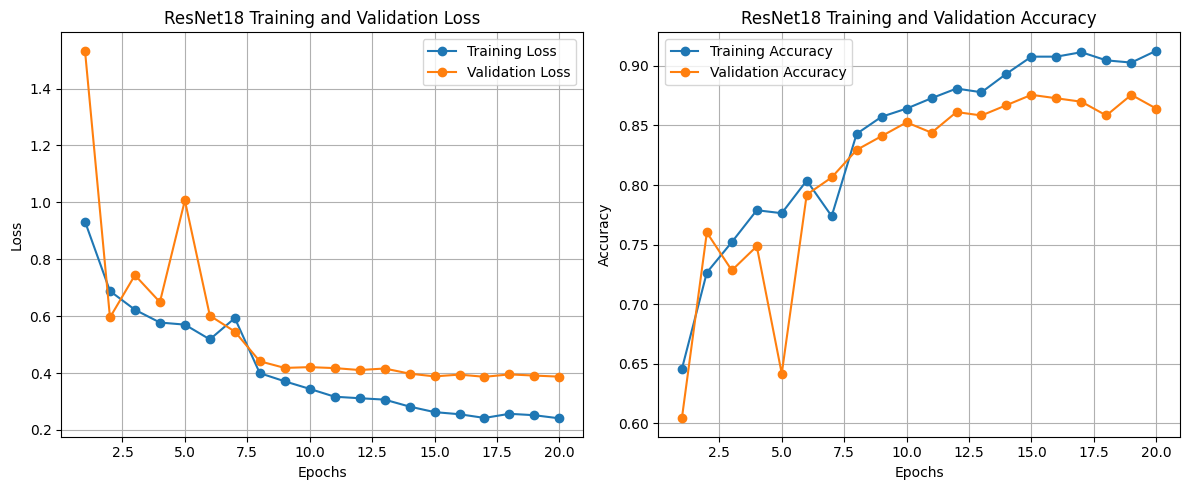


--- Evaluating ResNet18 on Test Set ---
Test Accuracy for ResNet18: 0.8513
Classification Report for ResNet18:
              precision    recall  f1-score   support

         abn       0.95      0.80      0.87       123
         bmt       0.65      0.76      0.70        29
        malg       0.63      0.80      0.70        40
         nml       0.89      0.95      0.92        65
         stn       0.92      0.91      0.91        86

    accuracy                           0.85       343
   macro avg       0.81      0.84      0.82       343
weighted avg       0.87      0.85      0.85       343



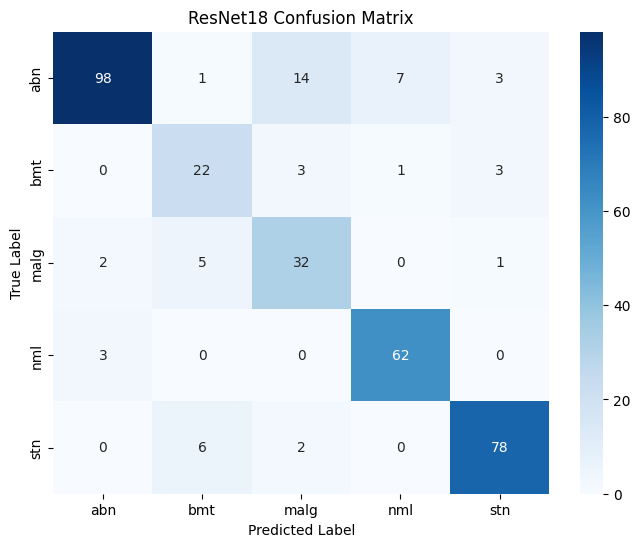

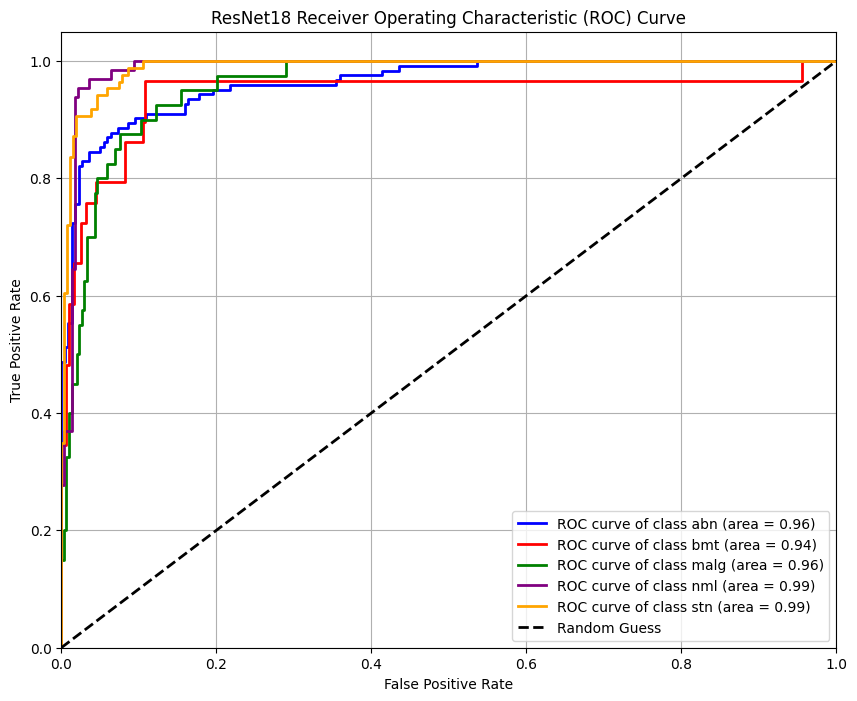

In [10]:
resnet18_model = get_model("resnet18", num_classes=len(class_names))
trained_resnet18_model, train_loss_r18, val_loss_r18, train_acc_r18, val_acc_r18 = train_model(resnet18_model, "ResNet18", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r18, val_loss_r18, train_acc_r18, val_acc_r18, "ResNet18")
y_true_r18, y_pred_classes_r18, y_pred_scores_r18 = evaluate_model_on_test(trained_resnet18_model, "ResNet18")
plot_confusion_matrix(y_true_r18, y_pred_classes_r18, class_names, "ResNet18")
plot_roc_curve(label_binarize(y_true_r18, classes=list(range(NUM_CLASSES))), y_pred_scores_r18, NUM_CLASSES, class_names, "ResNet18")
all_trained_models.append(trained_resnet18_model)

### Efficientnet_B0


--- Training EfficientNetB0 ---
Epoch 0/29
----------
training Loss: 0.8002 Acc: 0.6835
validation Loss: 0.6841 Acc: 0.7746
Epoch 1/29
----------
training Loss: 0.5531 Acc: 0.7894
validation Loss: 0.5523 Acc: 0.8179
Epoch 2/29
----------
training Loss: 0.4701 Acc: 0.8287
validation Loss: 0.4953 Acc: 0.8353
Epoch 3/29
----------
training Loss: 0.4139 Acc: 0.8430
validation Loss: 0.5361 Acc: 0.8179
Epoch 4/29
----------
training Loss: 0.3719 Acc: 0.8654
validation Loss: 0.6556 Acc: 0.8092
Epoch 5/29
----------
training Loss: 0.4248 Acc: 0.8424
validation Loss: 0.4661 Acc: 0.8439
Epoch 6/29
----------
training Loss: 0.3257 Acc: 0.8835
validation Loss: 0.5108 Acc: 0.8295
Epoch 7/29
----------
training Loss: 0.2212 Acc: 0.9159
validation Loss: 0.4305 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.1776 Acc: 0.9259
validation Loss: 0.4262 Acc: 0.8584
Epoch 9/29
----------
training Loss: 0.1452 Acc: 0.9464
validation Loss: 0.4028 Acc: 0.8728
Epoch 10/29
----------
training Loss: 0.1349 Ac

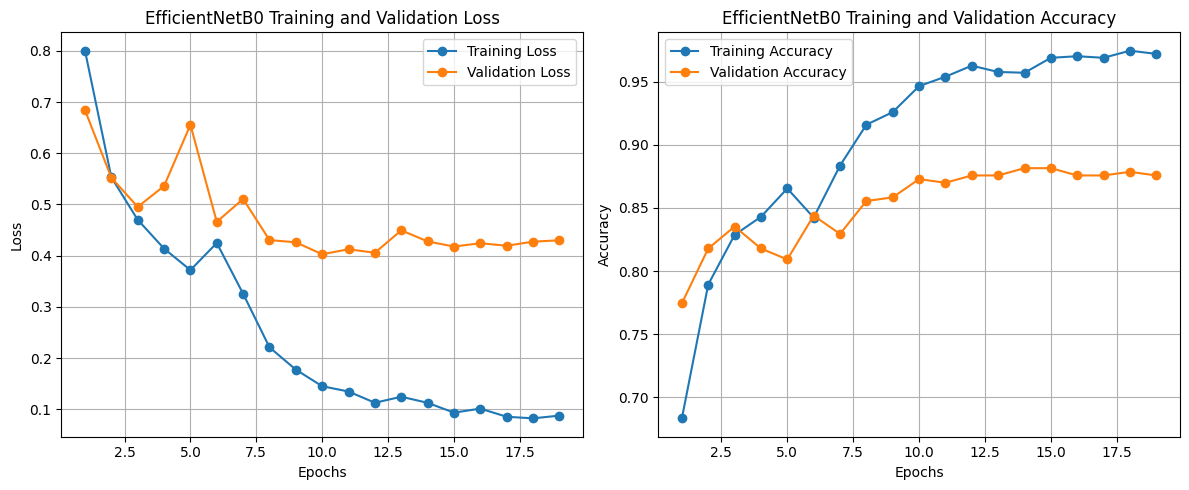


--- Evaluating EfficientNetB0 on Test Set ---
Test Accuracy for EfficientNetB0: 0.8630
Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

         abn       0.91      0.87      0.89       123
         bmt       0.71      0.59      0.64        29
        malg       0.66      0.78      0.71        40
         nml       0.92      0.92      0.92        65
         stn       0.91      0.94      0.93        86

    accuracy                           0.86       343
   macro avg       0.82      0.82      0.82       343
weighted avg       0.87      0.86      0.86       343



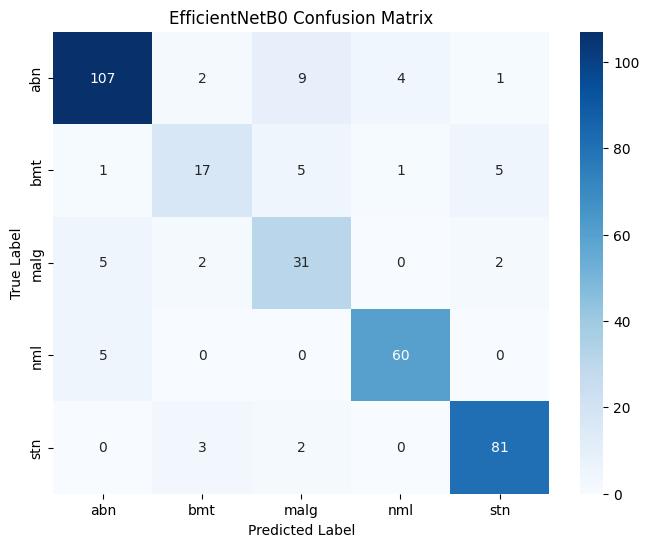

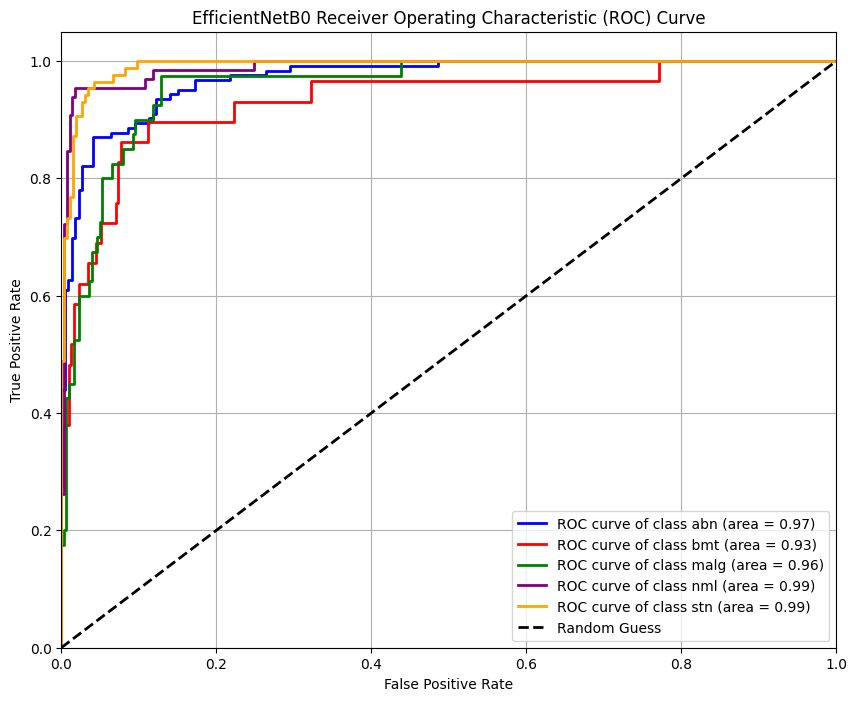

In [11]:
efficientnet_b0_model = get_model("efficientnet_b0", num_classes=len(class_names))
trained_efficientnet_b0_model, train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0 = train_model(efficientnet_b0_model, "EfficientNetB0", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0, "EfficientNetB0")
y_true_eb0, y_pred_classes_eb0, y_pred_scores_eb0 = evaluate_model_on_test(trained_efficientnet_b0_model, "EfficientNetB0")
plot_confusion_matrix(y_true_eb0, y_pred_classes_eb0, class_names, "EfficientNetB0")
plot_roc_curve(label_binarize(y_true_eb0, classes=list(range(NUM_CLASSES))), y_pred_scores_eb0, NUM_CLASSES, class_names, "EfficientNetB0")
all_trained_models.append(trained_efficientnet_b0_model)

### Densenet-121


--- Training DenseNet121 ---
Epoch 0/29
----------
training Loss: 0.8495 Acc: 0.6486
validation Loss: 1.8312 Acc: 0.4884
Epoch 1/29
----------
training Loss: 0.6713 Acc: 0.7383
validation Loss: 0.5828 Acc: 0.7977
Epoch 2/29
----------
training Loss: 0.6082 Acc: 0.7657
validation Loss: 0.6854 Acc: 0.7225
Epoch 3/29
----------
training Loss: 0.5221 Acc: 0.7925
validation Loss: 0.8889 Acc: 0.6647
Epoch 4/29
----------
training Loss: 0.5820 Acc: 0.7782
validation Loss: 0.7136 Acc: 0.7775
Epoch 5/29
----------
training Loss: 0.5118 Acc: 0.8056
validation Loss: 0.5923 Acc: 0.7977
Epoch 6/29
----------
training Loss: 0.4947 Acc: 0.8143
validation Loss: 0.4610 Acc: 0.8266
Epoch 7/29
----------
training Loss: 0.3841 Acc: 0.8555
validation Loss: 0.3823 Acc: 0.8671
Epoch 8/29
----------
training Loss: 0.3269 Acc: 0.8841
validation Loss: 0.3702 Acc: 0.8671
Epoch 9/29
----------
training Loss: 0.3002 Acc: 0.8941
validation Loss: 0.3715 Acc: 0.8642
Epoch 10/29
----------
training Loss: 0.2782 Acc: 

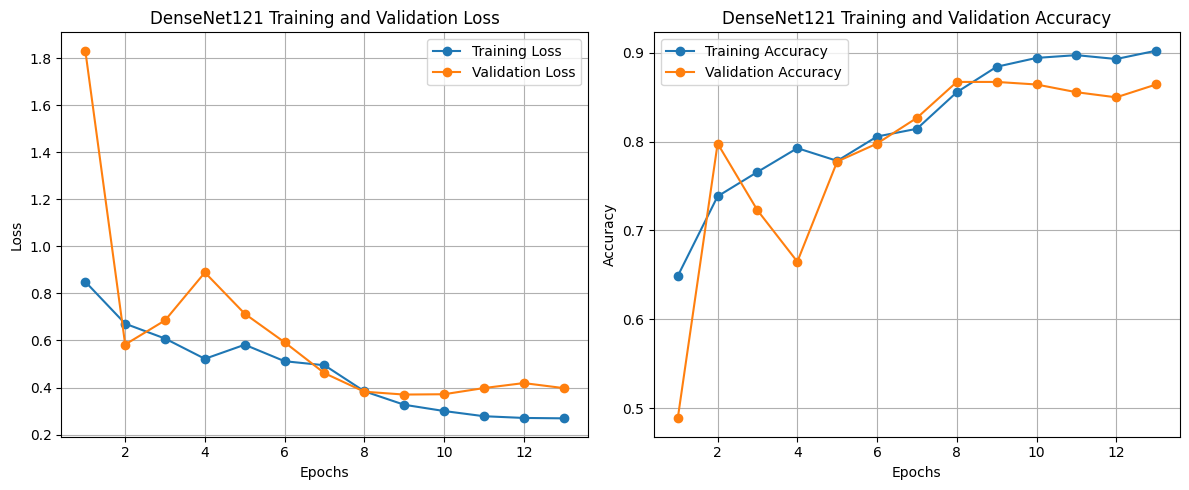


--- Evaluating DenseNet121 on Test Set ---
Test Accuracy for DenseNet121: 0.8513
Classification Report for DenseNet121:
              precision    recall  f1-score   support

         abn       0.92      0.83      0.87       123
         bmt       0.69      0.62      0.65        29
        malg       0.61      0.82      0.70        40
         nml       0.90      0.92      0.91        65
         stn       0.93      0.92      0.92        86

    accuracy                           0.85       343
   macro avg       0.81      0.82      0.81       343
weighted avg       0.86      0.85      0.85       343



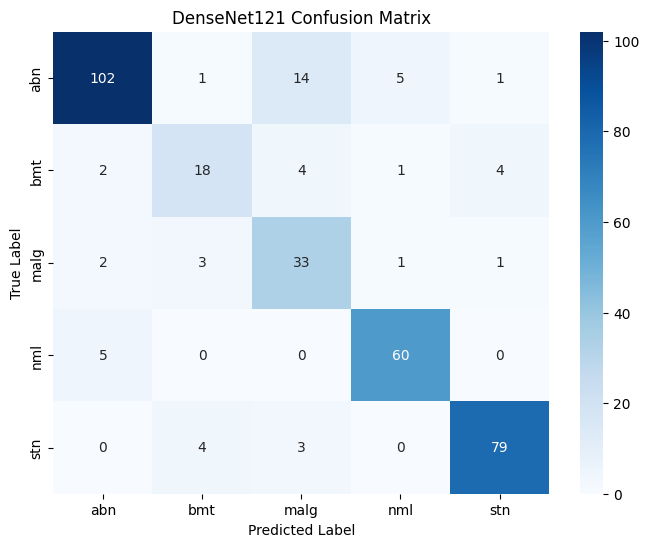

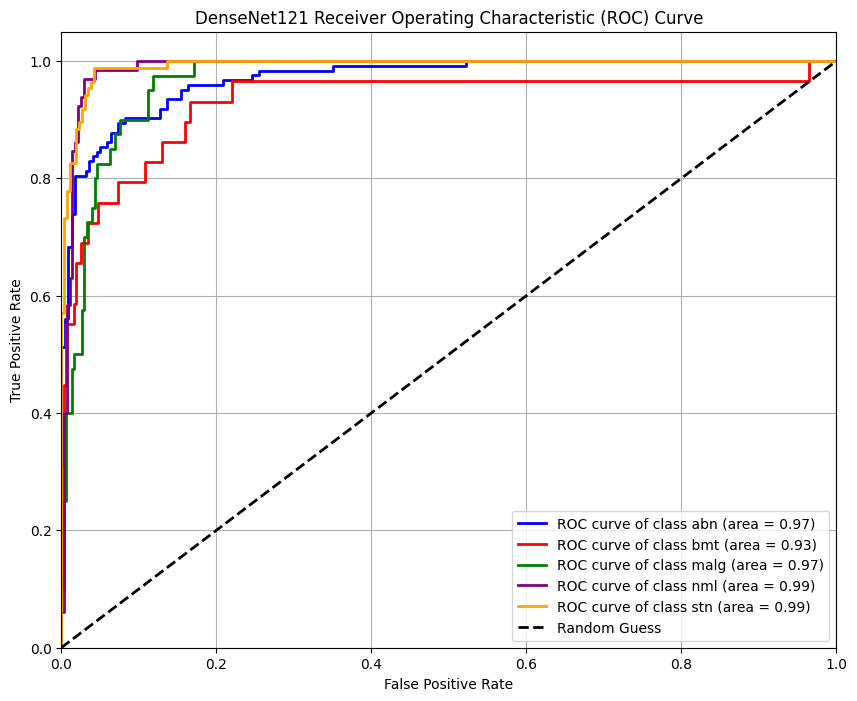

In [12]:
densenet121_model = get_model("densenet121", num_classes=len(class_names))
trained_densenet121_model, train_loss_d121, val_loss_d121, train_acc_d121, val_acc_d121 = train_model(densenet121_model, "DenseNet121", epochs=30, patience=5)
plot_accuracy_loss(train_loss_d121, val_loss_d121, train_acc_d121, val_acc_d121, "DenseNet121")
y_true_d121, y_pred_classes_d121, y_pred_scores_d121 = evaluate_model_on_test(trained_densenet121_model, "DenseNet121")
plot_confusion_matrix(y_true_d121, y_pred_classes_d121, class_names, "DenseNet121")
plot_roc_curve(label_binarize(y_true_d121, classes=list(range(NUM_CLASSES))), y_pred_scores_d121, NUM_CLASSES, class_names, "DenseNet121")
all_trained_models.append(trained_densenet121_model)

### MobileNetV2


--- Training MobileNetV2 ---
Epoch 0/29
----------
training Loss: 0.9105 Acc: 0.6305
validation Loss: 1.0293 Acc: 0.6936
Epoch 1/29
----------
training Loss: 0.6437 Acc: 0.7595
validation Loss: 0.5414 Acc: 0.7948
Epoch 2/29
----------
training Loss: 0.5675 Acc: 0.7738
validation Loss: 0.5826 Acc: 0.8064
Epoch 3/29
----------
training Loss: 0.5528 Acc: 0.7794
validation Loss: 0.5887 Acc: 0.8092
Epoch 4/29
----------
training Loss: 0.4958 Acc: 0.8187
validation Loss: 0.5605 Acc: 0.8092
Epoch 5/29
----------
training Loss: 0.4565 Acc: 0.8199
validation Loss: 0.7267 Acc: 0.7486
Epoch 6/29
----------
training Loss: 0.5312 Acc: 0.8037
validation Loss: 0.5618 Acc: 0.7919
Epoch 7/29
----------
training Loss: 0.3905 Acc: 0.8561
validation Loss: 0.4453 Acc: 0.8439
Epoch 8/29
----------
training Loss: 0.3350 Acc: 0.8822
validation Loss: 0.4163 Acc: 0.8728
Epoch 9/29
----------
training Loss: 0.3151 Acc: 0.8866
validation Loss: 0.4158 Acc: 0.8642
Epoch 10/29
----------
training Loss: 0.3034 Acc: 

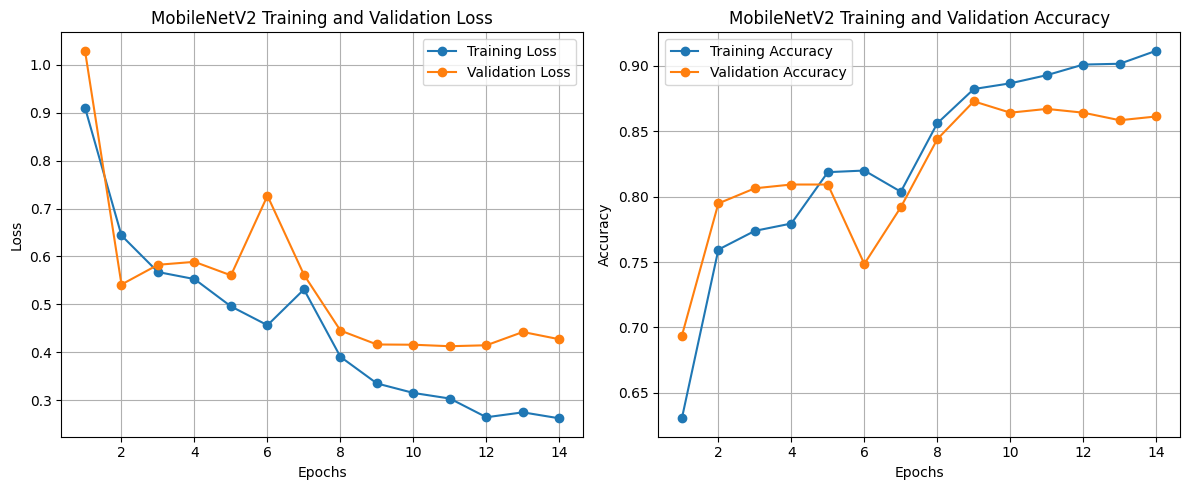


--- Evaluating MobileNetV2 on Test Set ---
Test Accuracy for MobileNetV2: 0.8601
Classification Report for MobileNetV2:
              precision    recall  f1-score   support

         abn       0.89      0.83      0.86       123
         bmt       0.78      0.72      0.75        29
        malg       0.64      0.85      0.73        40
         nml       0.92      0.89      0.91        65
         stn       0.93      0.93      0.93        86

    accuracy                           0.86       343
   macro avg       0.83      0.85      0.84       343
weighted avg       0.87      0.86      0.86       343



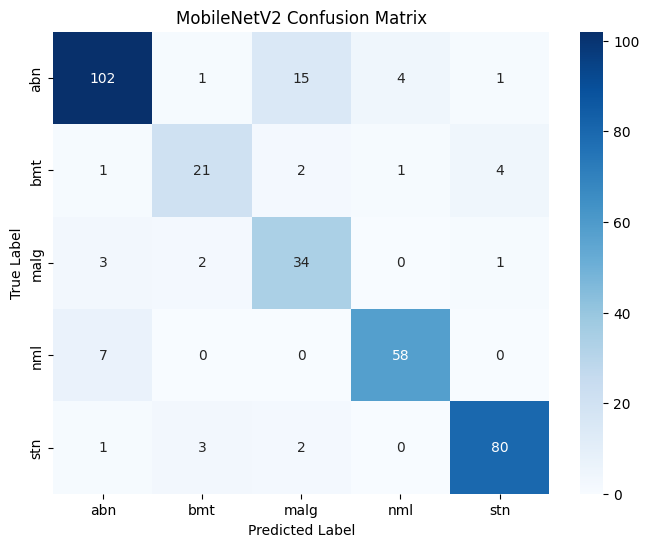

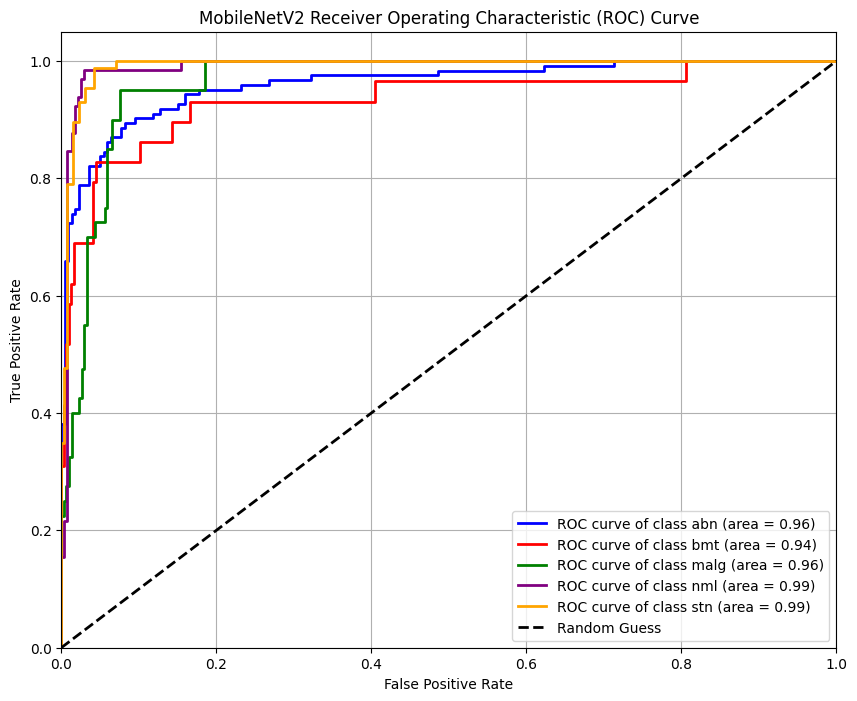

In [13]:
mobilenet_v2_model = get_model("mobilenet_v2", num_classes=len(class_names))
trained_mobilenet_v2_model, train_loss_mv2, val_loss_mv2, train_acc_mv2, val_acc_mv2 = train_model(mobilenet_v2_model, "MobileNetV2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_mv2, val_loss_mv2, train_acc_mv2, val_acc_mv2, "MobileNetV2")
y_true_mv2, y_pred_classes_mv2, y_pred_scores_mv2 = evaluate_model_on_test(trained_mobilenet_v2_model, "MobileNetV2")
plot_confusion_matrix(y_true_mv2, y_pred_classes_mv2, class_names, "MobileNetV2")
plot_roc_curve(label_binarize(y_true_mv2, classes=list(range(NUM_CLASSES))), y_pred_scores_mv2, NUM_CLASSES, class_names, "MobileNetV2")
all_trained_models.append(trained_mobilenet_v2_model)

### ShuffleNetV2


--- Training ShuffleNetV2 ---
Epoch 0/29
----------
training Loss: 1.0896 Acc: 0.6280
validation Loss: 0.7301 Acc: 0.7283
Epoch 1/29
----------
training Loss: 0.6521 Acc: 0.7607
validation Loss: 0.5929 Acc: 0.8035
Epoch 2/29
----------
training Loss: 0.5105 Acc: 0.8131
validation Loss: 0.5260 Acc: 0.7832
Epoch 3/29
----------
training Loss: 0.4661 Acc: 0.8262
validation Loss: 0.4803 Acc: 0.8237
Epoch 4/29
----------
training Loss: 0.4303 Acc: 0.8449
validation Loss: 0.5278 Acc: 0.8064
Epoch 5/29
----------
training Loss: 0.4107 Acc: 0.8536
validation Loss: 0.4836 Acc: 0.8150
Epoch 6/29
----------
training Loss: 0.3826 Acc: 0.8636
validation Loss: 0.4575 Acc: 0.8324
Epoch 7/29
----------
training Loss: 0.3036 Acc: 0.8978
validation Loss: 0.3971 Acc: 0.8526
Epoch 8/29
----------
training Loss: 0.2477 Acc: 0.9171
validation Loss: 0.3774 Acc: 0.8699
Epoch 9/29
----------
training Loss: 0.2407 Acc: 0.9140
validation Loss: 0.3809 Acc: 0.8728
Epoch 10/29
----------
training Loss: 0.2276 Acc:

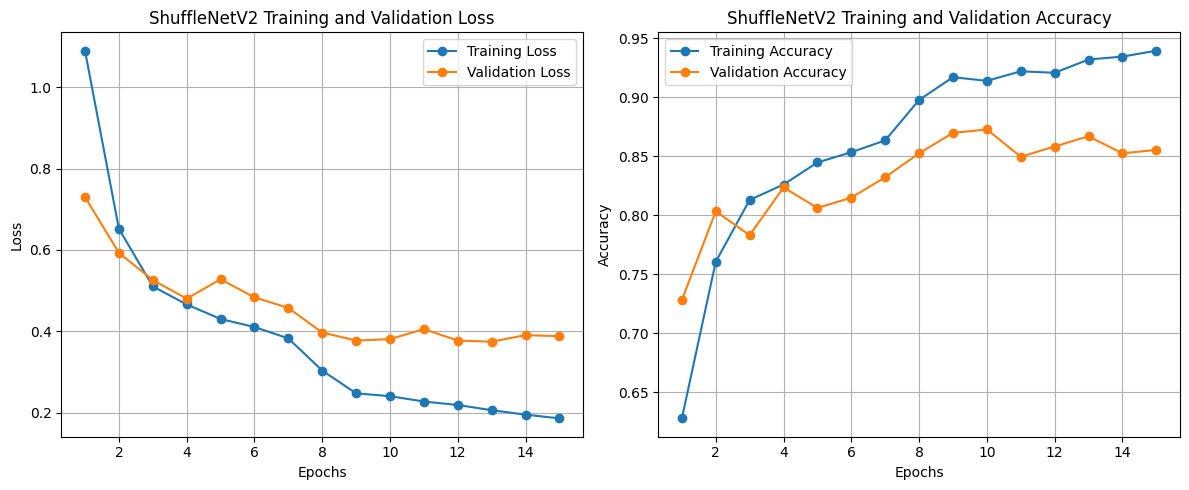


--- Evaluating ShuffleNetV2 on Test Set ---
Test Accuracy for ShuffleNetV2: 0.8367
Classification Report for ShuffleNetV2:
              precision    recall  f1-score   support

         abn       0.93      0.81      0.87       123
         bmt       0.62      0.62      0.62        29
        malg       0.60      0.82      0.69        40
         nml       0.91      0.91      0.91        65
         stn       0.90      0.90      0.90        86

    accuracy                           0.84       343
   macro avg       0.79      0.81      0.80       343
weighted avg       0.85      0.84      0.84       343



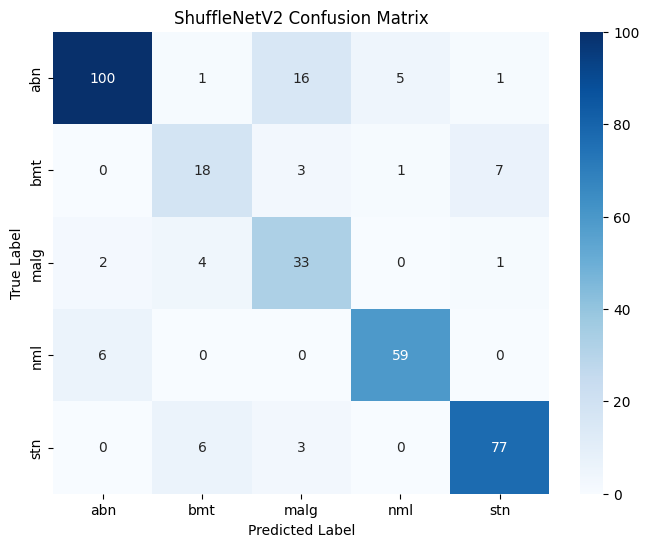

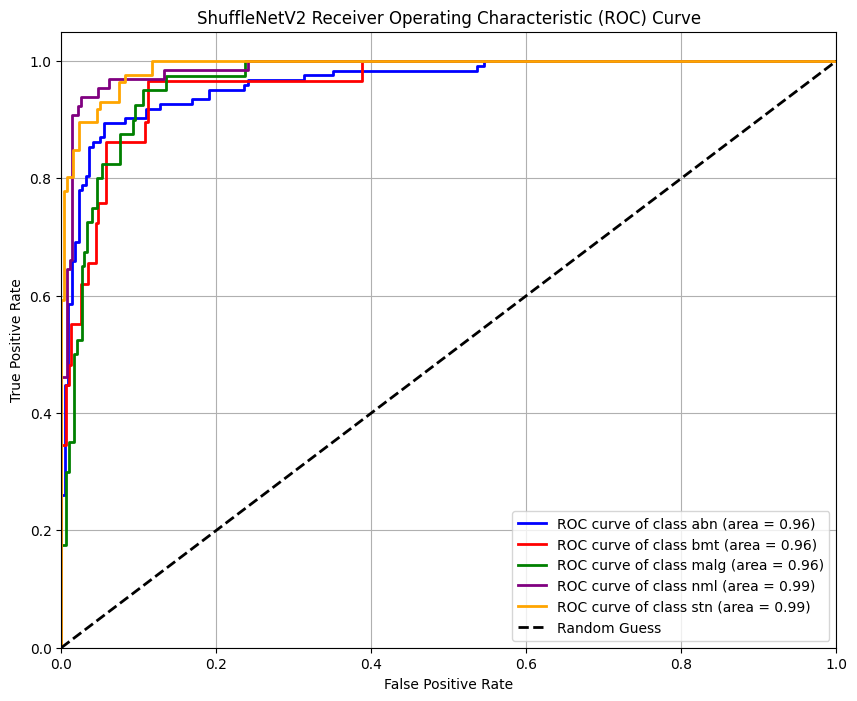

In [14]:
shufflenet_v2_model = get_model("shufflenet_v2", num_classes=len(class_names))
trained_shufflenet_v2_model, train_loss_sv2, val_loss_sv2, train_acc_sv2, val_acc_sv2 = train_model(shufflenet_v2_model, "ShuffleNetV2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_sv2, val_loss_sv2, train_acc_sv2, val_acc_sv2, "ShuffleNetV2")
y_true_sv2, y_pred_classes_sv2, y_pred_scores_sv2 = evaluate_model_on_test(trained_shufflenet_v2_model, "ShuffleNetV2")
plot_confusion_matrix(y_true_sv2, y_pred_classes_sv2, class_names, "ShuffleNetV2")
plot_roc_curve(label_binarize(y_true_sv2, classes=list(range(NUM_CLASSES))), y_pred_scores_sv2, NUM_CLASSES, class_names, "ShuffleNetV2")
all_trained_models.append(trained_shufflenet_v2_model)

### SqueezeNet1_0


--- Training SqueezeNet ---
Epoch 0/29
----------
training Loss: 1.4496 Acc: 0.4031
validation Loss: 1.4104 Acc: 0.4740
Epoch 1/29
----------
training Loss: 1.1870 Acc: 0.5483
validation Loss: 1.1186 Acc: 0.5694
Epoch 2/29
----------
training Loss: 1.1128 Acc: 0.5626
validation Loss: 1.0973 Acc: 0.5549
Epoch 3/29
----------
training Loss: 1.0985 Acc: 0.5670
validation Loss: 1.1220 Acc: 0.5491
Epoch 4/29
----------
training Loss: 1.0816 Acc: 0.5695
validation Loss: 1.0663 Acc: 0.6012
Epoch 5/29
----------
training Loss: 1.0364 Acc: 0.5632
validation Loss: 1.1036 Acc: 0.5983
Epoch 6/29
----------
training Loss: 1.0303 Acc: 0.5919
validation Loss: 1.1288 Acc: 0.5462
Epoch 7/29
----------
training Loss: 1.0058 Acc: 0.5751
validation Loss: 0.9502 Acc: 0.5983
Epoch 8/29
----------
training Loss: 0.9319 Acc: 0.6087
validation Loss: 0.9120 Acc: 0.6503
Epoch 9/29
----------
training Loss: 0.9020 Acc: 0.6293
validation Loss: 0.8987 Acc: 0.6503
Epoch 10/29
----------
training Loss: 0.8835 Acc: 0

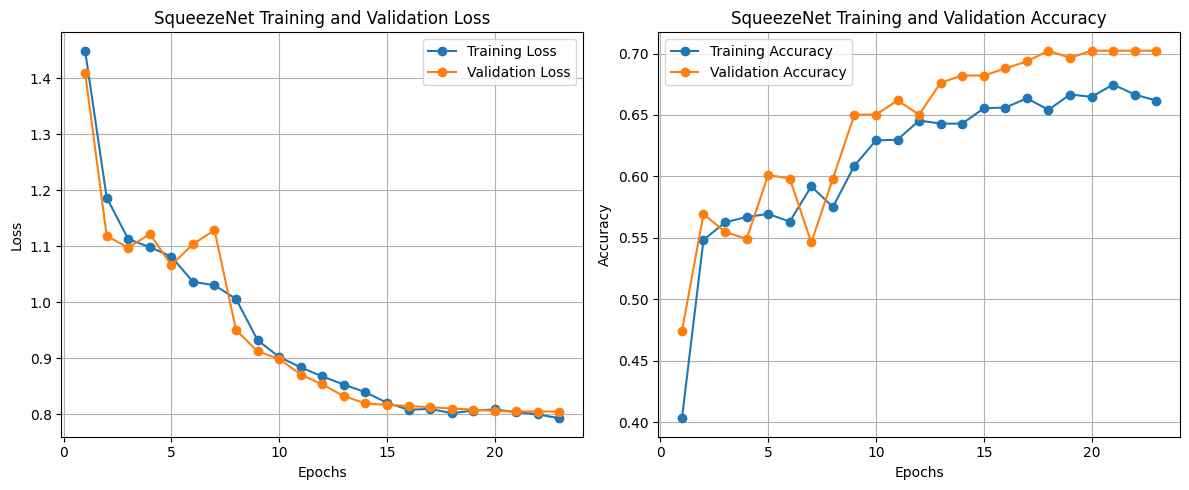


--- Evaluating SqueezeNet on Test Set ---
Test Accuracy for SqueezeNet: 0.6735
Classification Report for SqueezeNet:
              precision    recall  f1-score   support

         abn       0.64      0.89      0.74       123
         bmt       0.29      0.07      0.11        29
        malg       0.75      0.15      0.25        40
         nml       0.76      0.54      0.63        65
         stn       0.71      0.92      0.80        86

    accuracy                           0.67       343
   macro avg       0.63      0.51      0.51       343
weighted avg       0.66      0.67      0.63       343



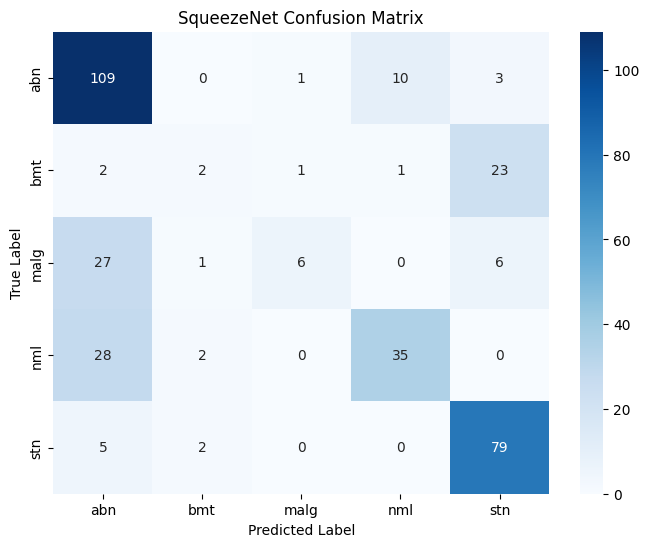

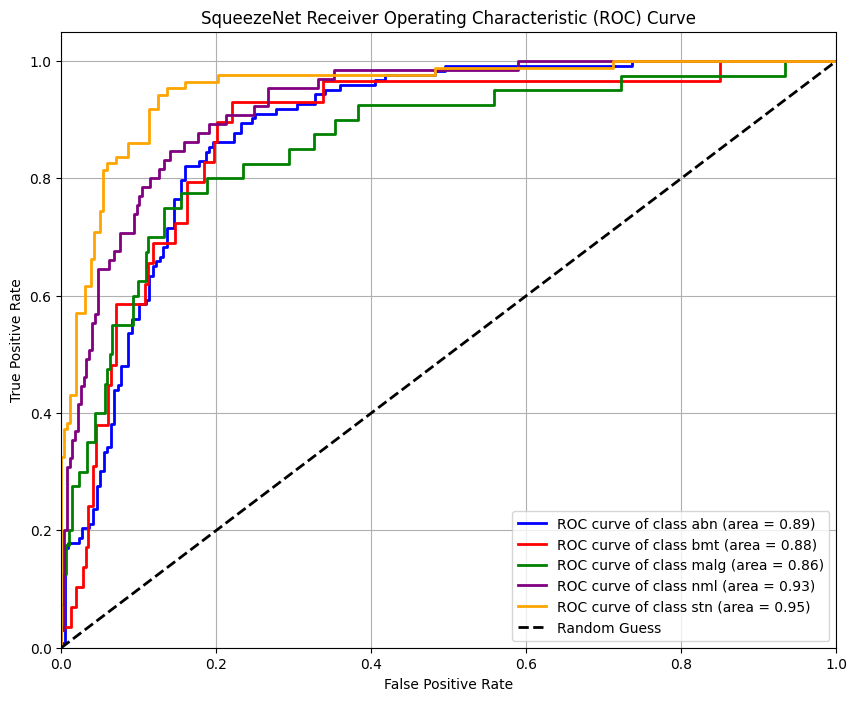

In [15]:
squeezenet_model = get_model("squeezenet", num_classes=len(class_names))
trained_squeezenet_model, train_loss_sqz, val_loss_sqz, train_acc_sqz, val_acc_sqz = train_model(squeezenet_model, "SqueezeNet", epochs=30, patience=5)
plot_accuracy_loss(train_loss_sqz, val_loss_sqz, train_acc_sqz, val_acc_sqz, "SqueezeNet")
y_true_sqz, y_pred_classes_sqz, y_pred_scores_sqz = evaluate_model_on_test(trained_squeezenet_model, "SqueezeNet")
plot_confusion_matrix(y_true_sqz, y_pred_classes_sqz, class_names, "SqueezeNet")
plot_roc_curve(label_binarize(y_true_sqz, classes=list(range(NUM_CLASSES))), y_pred_scores_sqz, NUM_CLASSES, class_names, "SqueezeNet")
all_trained_models.append(trained_squeezenet_model)

### Densenet201


--- Training DenseNet201 ---
Epoch 0/29
----------
training Loss: 0.8783 Acc: 0.6424
validation Loss: 0.7859 Acc: 0.7110
Epoch 1/29
----------
training Loss: 0.6352 Acc: 0.7576
validation Loss: 0.8107 Acc: 0.7225
Epoch 2/29
----------
training Loss: 0.5803 Acc: 0.7695
validation Loss: 0.6220 Acc: 0.7572
Epoch 3/29
----------
training Loss: 0.5816 Acc: 0.7682
validation Loss: 0.6479 Acc: 0.7717
Epoch 4/29
----------
training Loss: 0.5591 Acc: 0.7888
validation Loss: 0.6172 Acc: 0.7688
Epoch 5/29
----------
training Loss: 0.5249 Acc: 0.7938
validation Loss: 0.4815 Acc: 0.8237
Epoch 6/29
----------
training Loss: 0.4496 Acc: 0.8293
validation Loss: 0.6441 Acc: 0.7775
Epoch 7/29
----------
training Loss: 0.3990 Acc: 0.8449
validation Loss: 0.4031 Acc: 0.8526
Epoch 8/29
----------
training Loss: 0.3258 Acc: 0.8773
validation Loss: 0.3806 Acc: 0.8468
Epoch 9/29
----------
training Loss: 0.3013 Acc: 0.8941
validation Loss: 0.3904 Acc: 0.8613
Epoch 10/29
----------
training Loss: 0.2844 Acc: 

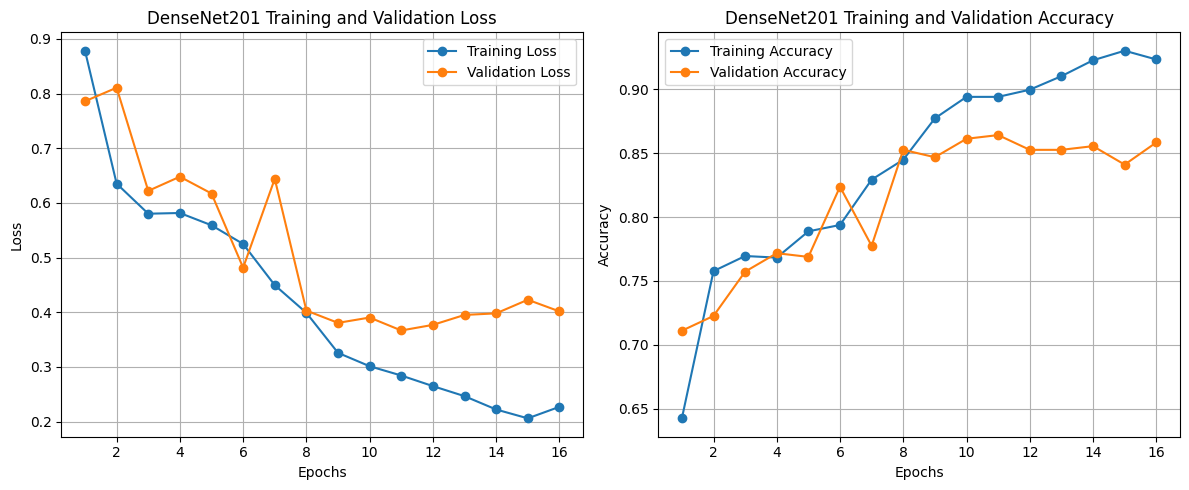


--- Evaluating DenseNet201 on Test Set ---
Test Accuracy for DenseNet201: 0.8571
Classification Report for DenseNet201:
              precision    recall  f1-score   support

         abn       0.92      0.83      0.87       123
         bmt       0.69      0.69      0.69        29
        malg       0.65      0.82      0.73        40
         nml       0.90      0.94      0.92        65
         stn       0.93      0.91      0.92        86

    accuracy                           0.86       343
   macro avg       0.82      0.84      0.82       343
weighted avg       0.87      0.86      0.86       343



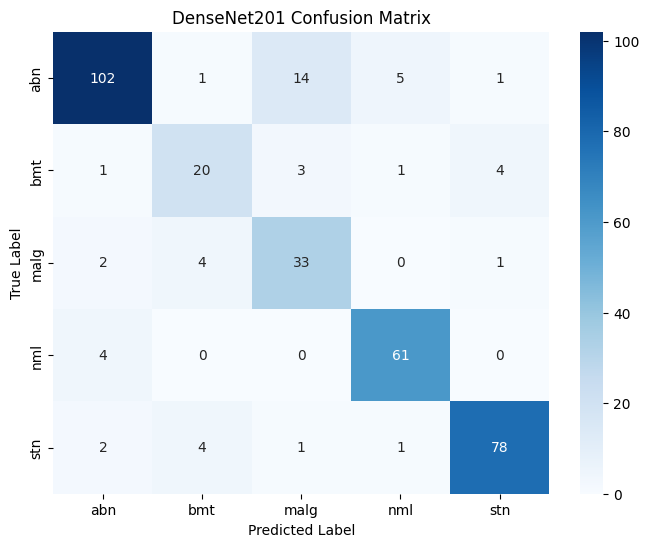

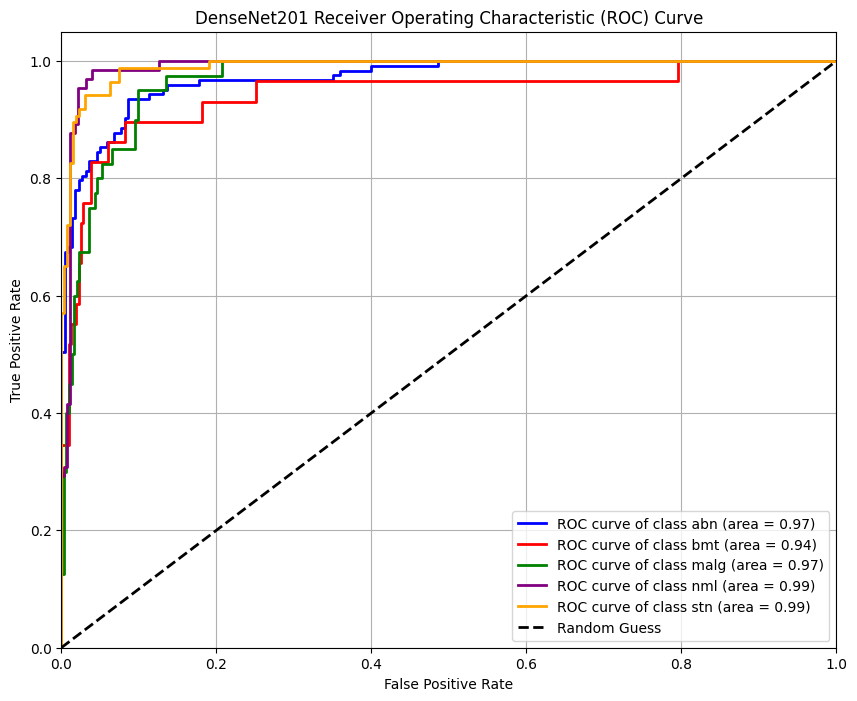

In [16]:
densenet201_model = get_model("densenet201", num_classes=len(class_names))
trained_densenet201_model, train_loss_d201, val_loss_d201, train_acc_d201, val_acc_d201 = train_model(densenet201_model, "DenseNet201", epochs=30, patience=5)
plot_accuracy_loss(train_loss_d201, val_loss_d201, train_acc_d201, val_acc_d201, "DenseNet201")
y_true_d201, y_pred_classes_d201, y_pred_scores_d201 = evaluate_model_on_test(trained_densenet201_model, "DenseNet201")
plot_confusion_matrix(y_true_d201, y_pred_classes_d201, class_names, "DenseNet201")
plot_roc_curve(label_binarize(y_true_d201, classes=list(range(NUM_CLASSES))), y_pred_scores_d201, NUM_CLASSES, class_names, "DenseNet201")
all_trained_models.append(trained_densenet201_model)

### EfficientNet-B1


--- Training EfficientNetB1 ---
Epoch 0/29
----------
training Loss: 0.7794 Acc: 0.7134
validation Loss: 0.6321 Acc: 0.7948
Epoch 1/29
----------
training Loss: 0.5499 Acc: 0.7900
validation Loss: 0.5242 Acc: 0.8150
Epoch 2/29
----------
training Loss: 0.4210 Acc: 0.8517
validation Loss: 0.4420 Acc: 0.8468
Epoch 3/29
----------
training Loss: 0.4016 Acc: 0.8498
validation Loss: 0.4575 Acc: 0.8526
Epoch 4/29
----------
training Loss: 0.3010 Acc: 0.8847
validation Loss: 0.4458 Acc: 0.8526
Epoch 5/29
----------
training Loss: 0.2928 Acc: 0.8854
validation Loss: 0.5053 Acc: 0.8324
Epoch 6/29
----------
training Loss: 0.2456 Acc: 0.9109
validation Loss: 0.6419 Acc: 0.7890
Epoch 7/29
----------
training Loss: 0.1938 Acc: 0.9346
validation Loss: 0.4519 Acc: 0.8584
Epoch 8/29
----------
training Loss: 0.1222 Acc: 0.9564
validation Loss: 0.4388 Acc: 0.8613
Epoch 9/29
----------
training Loss: 0.1010 Acc: 0.9626
validation Loss: 0.4469 Acc: 0.8671
Epoch 10/29
----------
training Loss: 0.0894 Ac

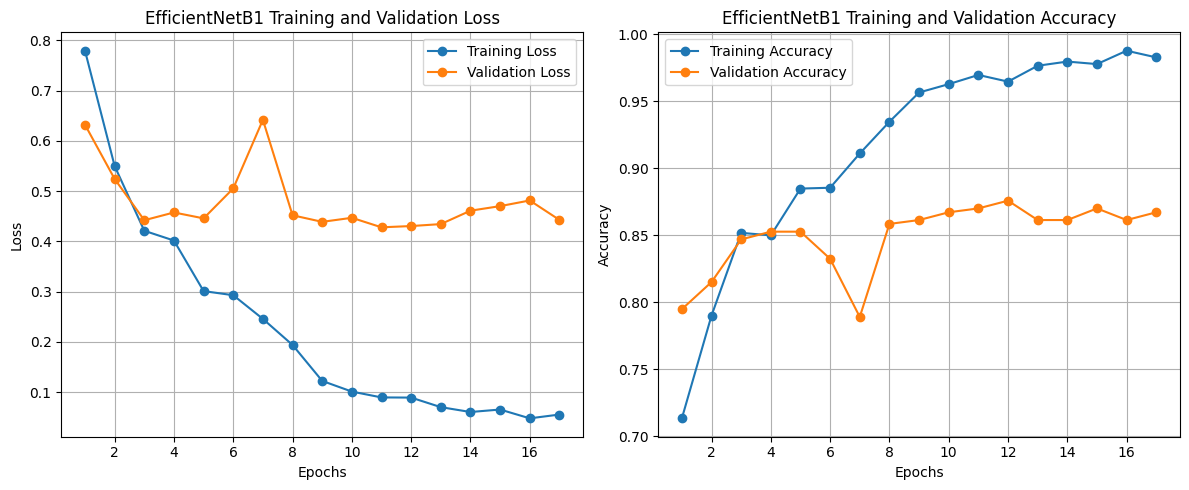


--- Evaluating EfficientNetB1 on Test Set ---
Test Accuracy for EfficientNetB1: 0.8542
Classification Report for EfficientNetB1:
              precision    recall  f1-score   support

         abn       0.90      0.85      0.88       123
         bmt       0.70      0.66      0.68        29
        malg       0.61      0.78      0.68        40
         nml       0.92      0.94      0.93        65
         stn       0.94      0.90      0.92        86

    accuracy                           0.85       343
   macro avg       0.81      0.82      0.82       343
weighted avg       0.86      0.85      0.86       343



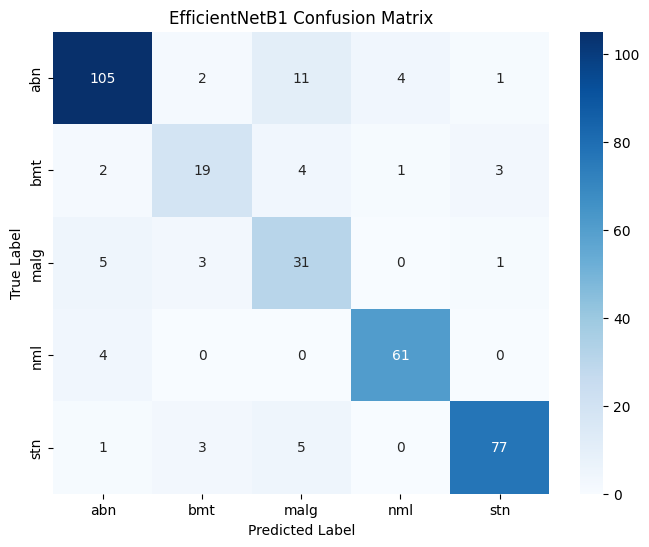

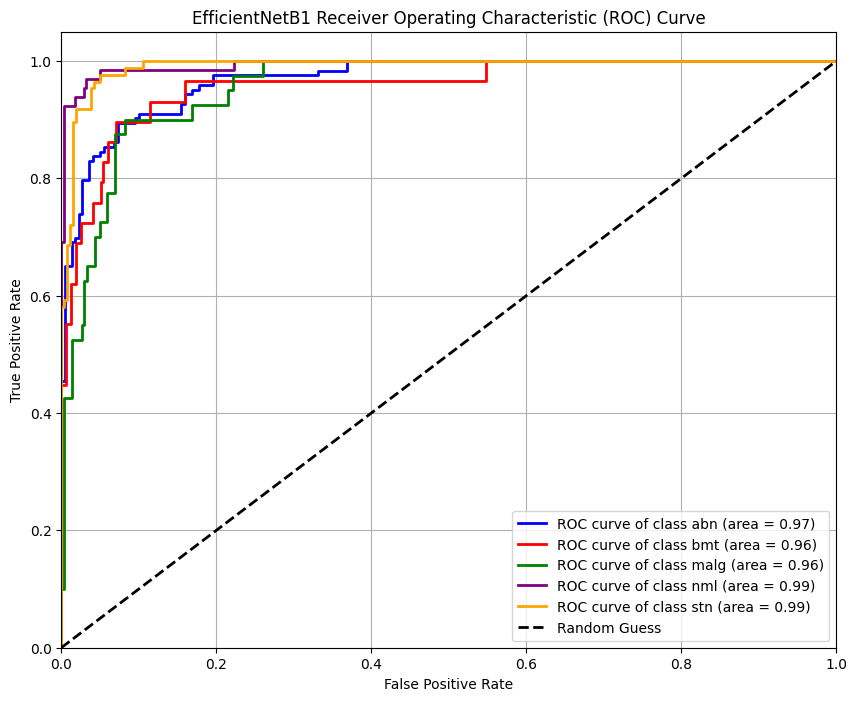

In [17]:
efficientnet_b1_model = get_model("efficientnet_b1", num_classes=len(class_names))
trained_efficientnet_b1_model, train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1 = train_model(efficientnet_b1_model, "EfficientNetB1", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1, "EfficientNetB1")
y_true_eb1, y_pred_classes_eb1, y_pred_scores_eb1 = evaluate_model_on_test(trained_efficientnet_b1_model, "EfficientNetB1")
plot_confusion_matrix(y_true_eb1, y_pred_classes_eb1, class_names, "EfficientNetB1")
plot_roc_curve(label_binarize(y_true_eb1, classes=list(range(NUM_CLASSES))), y_pred_scores_eb1, NUM_CLASSES, class_names, "EfficientNetB1")
all_trained_models.append(trained_efficientnet_b1_model)

### EfficientNet-B2


--- Training EfficientNetB2 ---
Epoch 0/29
----------
training Loss: 0.7959 Acc: 0.7121
validation Loss: 1.0604 Acc: 0.7486
Epoch 1/29
----------
training Loss: 0.6062 Acc: 0.7807
validation Loss: 0.5782 Acc: 0.7948
Epoch 2/29
----------
training Loss: 0.5019 Acc: 0.8037
validation Loss: 0.4647 Acc: 0.8237
Epoch 3/29
----------
training Loss: 0.4561 Acc: 0.8305
validation Loss: 0.6051 Acc: 0.7514
Epoch 4/29
----------
training Loss: 0.4220 Acc: 0.8474
validation Loss: 0.5189 Acc: 0.8121
Epoch 5/29
----------
training Loss: 0.3417 Acc: 0.8698
validation Loss: 0.3913 Acc: 0.8497
Epoch 6/29
----------
training Loss: 0.3459 Acc: 0.8835
validation Loss: 0.4415 Acc: 0.8526
Epoch 7/29
----------
training Loss: 0.2140 Acc: 0.9215
validation Loss: 0.3666 Acc: 0.8699
Epoch 8/29
----------
training Loss: 0.1888 Acc: 0.9308
validation Loss: 0.3513 Acc: 0.8902
Epoch 9/29
----------
training Loss: 0.1568 Acc: 0.9427
validation Loss: 0.3575 Acc: 0.8844
Epoch 10/29
----------
training Loss: 0.1295 Ac

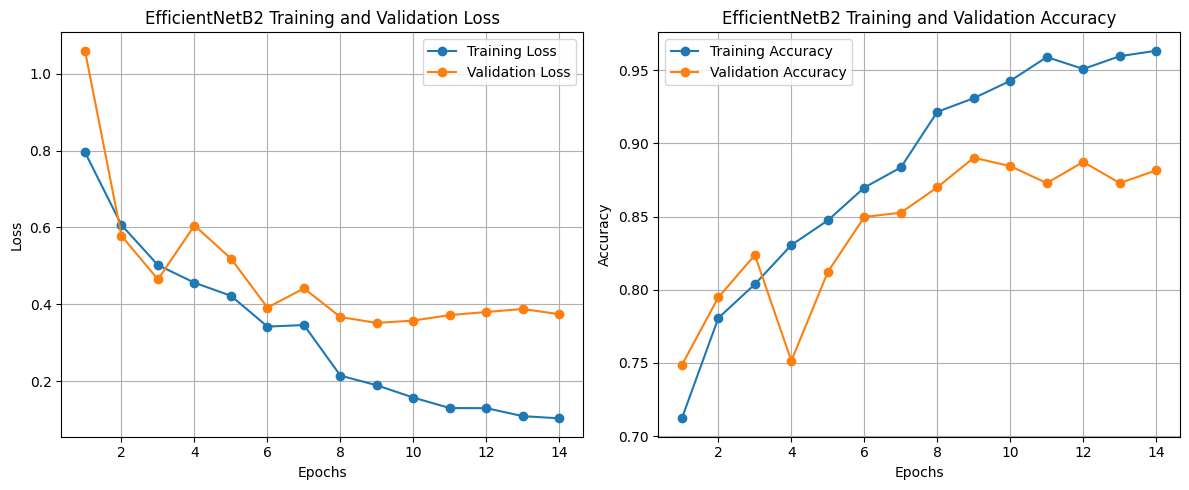


--- Evaluating EfficientNetB2 on Test Set ---
Test Accuracy for EfficientNetB2: 0.8338
Classification Report for EfficientNetB2:
              precision    recall  f1-score   support

         abn       0.86      0.80      0.83       123
         bmt       0.79      0.79      0.79        29
        malg       0.52      0.62      0.57        40
         nml       0.91      0.91      0.91        65
         stn       0.93      0.93      0.93        86

    accuracy                           0.83       343
   macro avg       0.80      0.81      0.81       343
weighted avg       0.84      0.83      0.84       343



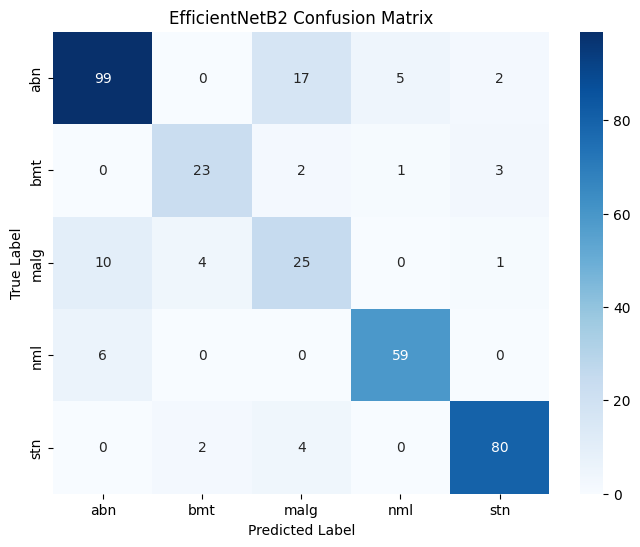

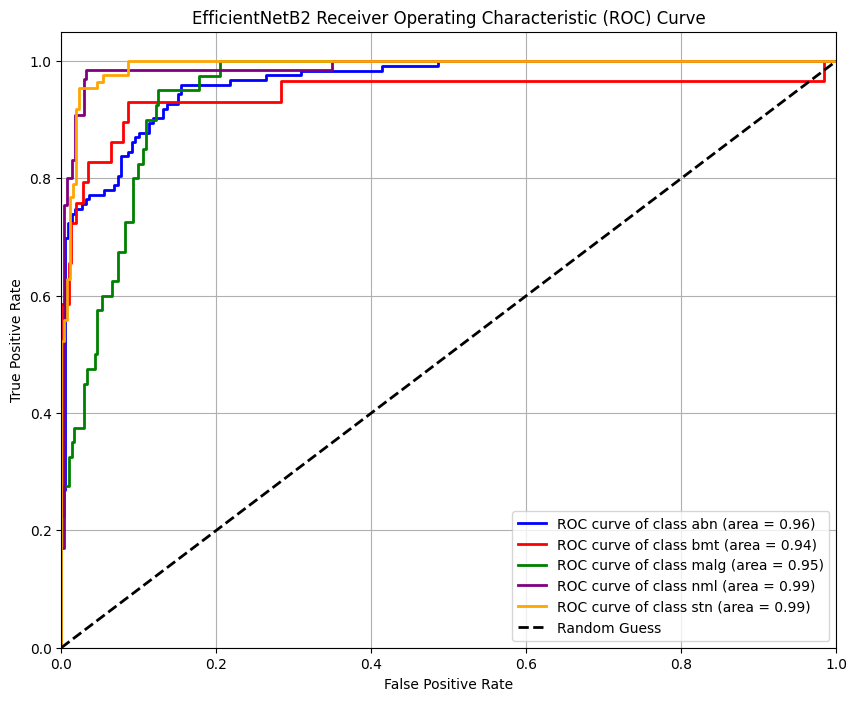

In [18]:
efficientnet_b2_model = get_model("efficientnet_b2", num_classes=len(class_names))
trained_efficientnet_b2_model, train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2 = train_model(efficientnet_b2_model, "EfficientNetB2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2, "EfficientNetB2")
y_true_eb2, y_pred_classes_eb2, y_pred_scores_eb2 = evaluate_model_on_test(trained_efficientnet_b2_model, "EfficientNetB2")
plot_confusion_matrix(y_true_eb2, y_pred_classes_eb2, class_names, "EfficientNetB2")
plot_roc_curve(label_binarize(y_true_eb2, classes=list(range(NUM_CLASSES))), y_pred_scores_eb2, NUM_CLASSES, class_names, "EfficientNetB2")
all_trained_models.append(trained_efficientnet_b2_model)

### EfficientNet-B3


--- Training EfficientNetB3 ---
Epoch 0/29
----------
training Loss: 0.8155 Acc: 0.6953
validation Loss: 0.5812 Acc: 0.7890
Epoch 1/29
----------
training Loss: 0.5518 Acc: 0.7882
validation Loss: 0.5471 Acc: 0.7890
Epoch 2/29
----------
training Loss: 0.4800 Acc: 0.8087
validation Loss: 0.4873 Acc: 0.8382
Epoch 3/29
----------
training Loss: 0.3863 Acc: 0.8592
validation Loss: 0.5313 Acc: 0.8064
Epoch 4/29
----------
training Loss: 0.3411 Acc: 0.8748
validation Loss: 0.5668 Acc: 0.8150
Epoch 5/29
----------
training Loss: 0.2874 Acc: 0.8972
validation Loss: 0.5252 Acc: 0.8266
Epoch 6/29
----------
training Loss: 0.2989 Acc: 0.8947
validation Loss: 0.6088 Acc: 0.8121
Epoch 7/29
----------
training Loss: 0.1906 Acc: 0.9240
validation Loss: 0.4860 Acc: 0.8353
Early stopping triggered.
Best val Acc: 0.8382


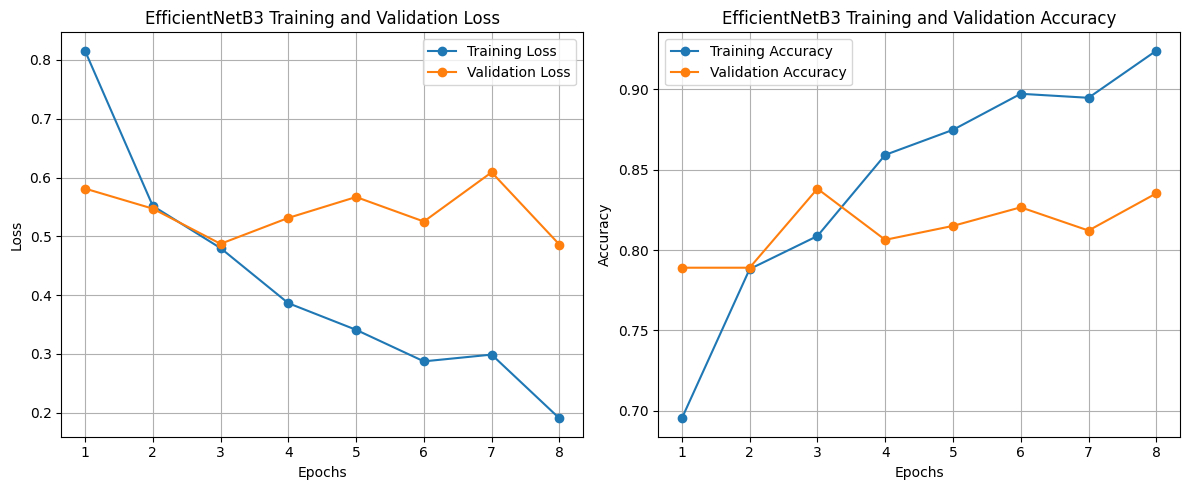


--- Evaluating EfficientNetB3 on Test Set ---
Test Accuracy for EfficientNetB3: 0.8338
Classification Report for EfficientNetB3:
              precision    recall  f1-score   support

         abn       0.87      0.82      0.85       123
         bmt       0.63      0.66      0.64        29
        malg       0.66      0.62      0.64        40
         nml       0.89      0.97      0.93        65
         stn       0.89      0.91      0.90        86

    accuracy                           0.83       343
   macro avg       0.79      0.80      0.79       343
weighted avg       0.83      0.83      0.83       343



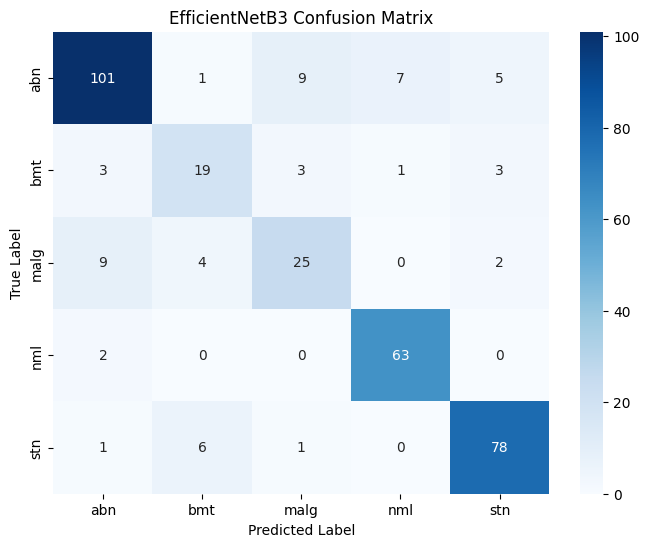

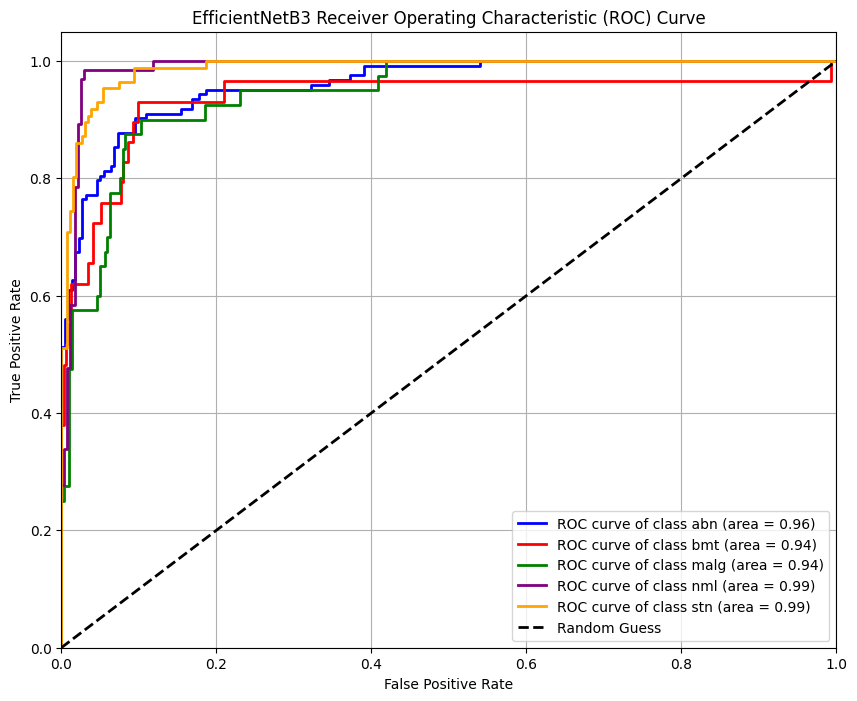

In [19]:
efficientnet_b3_model = get_model("efficientnet_b3", num_classes=len(class_names))
trained_efficientnet_b3_model, train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3 = train_model(efficientnet_b3_model, "EfficientNetB3", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3, "EfficientNetB3")
y_true_eb3, y_pred_classes_eb3, y_pred_scores_eb3 = evaluate_model_on_test(trained_efficientnet_b3_model, "EfficientNetB3")
plot_confusion_matrix(y_true_eb3, y_pred_classes_eb3, class_names, "EfficientNetB3")
plot_roc_curve(label_binarize(y_true_eb3, classes=list(range(NUM_CLASSES))), y_pred_scores_eb3, NUM_CLASSES, class_names, "EfficientNetB3")
all_trained_models.append(trained_efficientnet_b3_model)

### EfficientNet-B4


--- Training EfficientNetB4 ---
Epoch 0/29
----------
training Loss: 0.8862 Acc: 0.6685
validation Loss: 0.8321 Acc: 0.7225
Epoch 1/29
----------
training Loss: 0.5197 Acc: 0.7950
validation Loss: 0.5083 Acc: 0.7948
Epoch 2/29
----------
training Loss: 0.4058 Acc: 0.8517
validation Loss: 0.4823 Acc: 0.8121
Epoch 3/29
----------
training Loss: 0.3423 Acc: 0.8754
validation Loss: 0.5347 Acc: 0.7948
Epoch 4/29
----------
training Loss: 0.3178 Acc: 0.8866
validation Loss: 0.4904 Acc: 0.7948
Epoch 5/29
----------
training Loss: 0.2775 Acc: 0.8991
validation Loss: 0.5382 Acc: 0.8150
Epoch 6/29
----------
training Loss: 0.1978 Acc: 0.9265
validation Loss: 0.5843 Acc: 0.8237
Epoch 7/29
----------
training Loss: 0.1289 Acc: 0.9502
validation Loss: 0.5469 Acc: 0.8353
Epoch 8/29
----------
training Loss: 0.1033 Acc: 0.9639
validation Loss: 0.5741 Acc: 0.8353
Epoch 9/29
----------
training Loss: 0.0911 Acc: 0.9682
validation Loss: 0.5517 Acc: 0.8526
Epoch 10/29
----------
training Loss: 0.0886 Ac

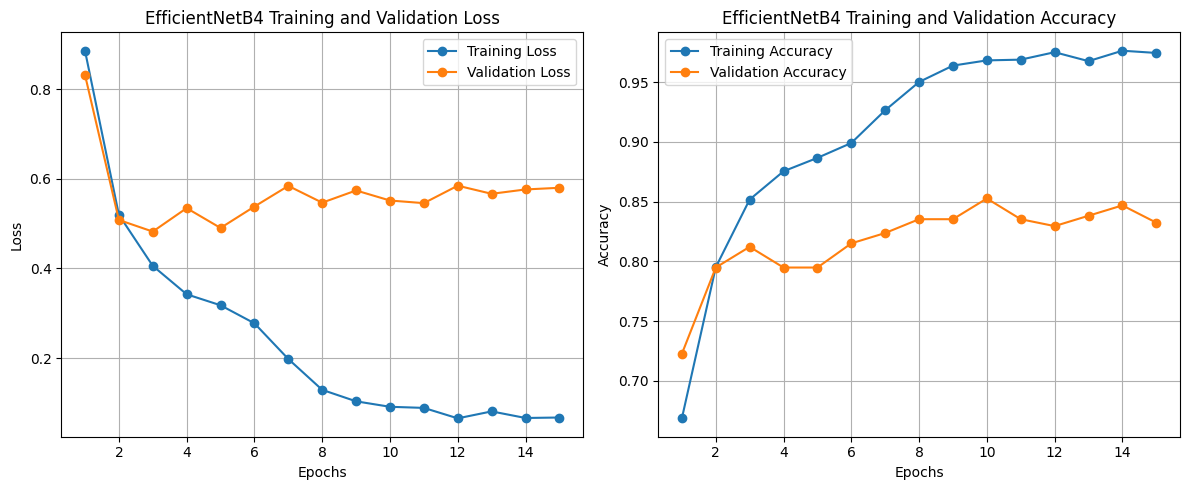


--- Evaluating EfficientNetB4 on Test Set ---
Test Accuracy for EfficientNetB4: 0.8484
Classification Report for EfficientNetB4:
              precision    recall  f1-score   support

         abn       0.89      0.82      0.85       123
         bmt       0.80      0.69      0.74        29
        malg       0.60      0.75      0.67        40
         nml       0.91      0.91      0.91        65
         stn       0.91      0.94      0.93        86

    accuracy                           0.85       343
   macro avg       0.82      0.82      0.82       343
weighted avg       0.86      0.85      0.85       343



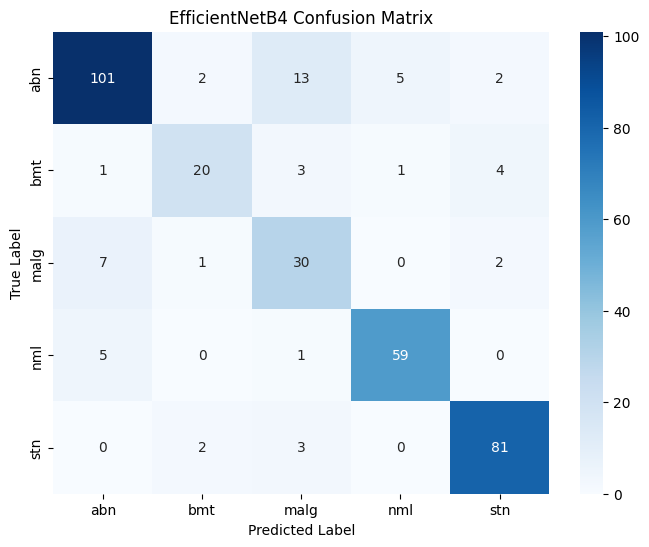

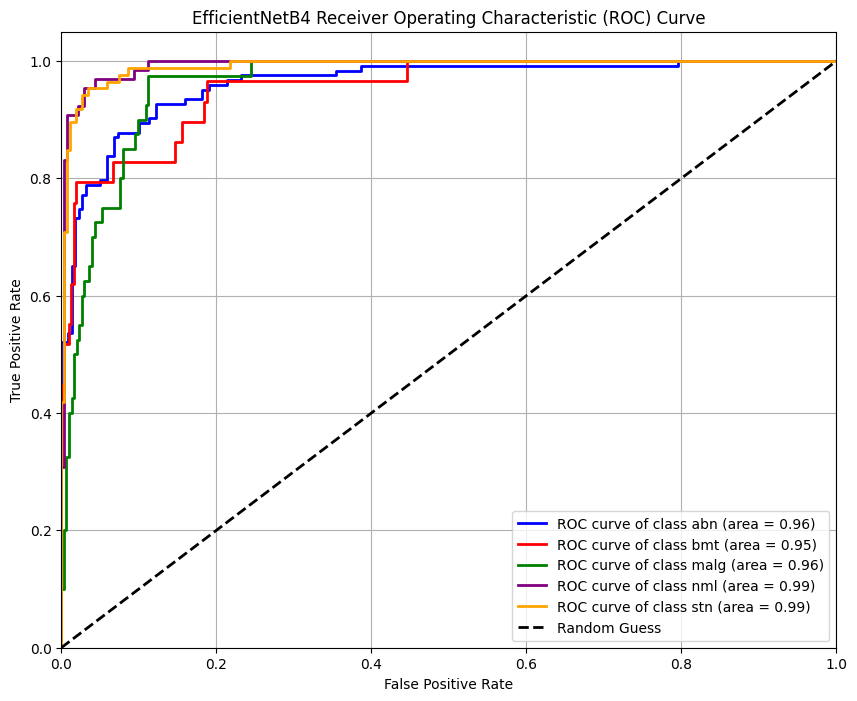

In [20]:
efficientnet_b4_model = get_model("efficientnet_b4", num_classes=len(class_names))
trained_efficientnet_b4_model, train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4 = train_model(efficientnet_b4_model, "EfficientNetB4", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4, "EfficientNetB4")
y_true_eb4, y_pred_classes_eb4, y_pred_scores_eb4 = evaluate_model_on_test(trained_efficientnet_b4_model, "EfficientNetB4")
plot_confusion_matrix(y_true_eb4, y_pred_classes_eb4, class_names, "EfficientNetB4")
plot_roc_curve(label_binarize(y_true_eb4, classes=list(range(NUM_CLASSES))), y_pred_scores_eb4, NUM_CLASSES, class_names, "EfficientNetB4")
all_trained_models.append(trained_efficientnet_b4_model)

### ResNet-50 V1


--- Training ResNet50V1 ---
Epoch 0/29
----------
training Loss: 1.0565 Acc: 0.5745
validation Loss: 1.6043 Acc: 0.5491
Epoch 1/29
----------
training Loss: 0.8078 Acc: 0.6816
validation Loss: 1.6888 Acc: 0.5491
Epoch 2/29
----------
training Loss: 0.7300 Acc: 0.7103
validation Loss: 0.7789 Acc: 0.7225
Epoch 3/29
----------
training Loss: 0.7106 Acc: 0.7090
validation Loss: 0.6650 Acc: 0.7601
Epoch 4/29
----------
training Loss: 0.6510 Acc: 0.7458
validation Loss: 0.7865 Acc: 0.6705
Epoch 5/29
----------
training Loss: 0.6547 Acc: 0.7321
validation Loss: 0.9319 Acc: 0.6590
Epoch 6/29
----------
training Loss: 0.6418 Acc: 0.7439
validation Loss: 0.7457 Acc: 0.7283
Epoch 7/29
----------
training Loss: 0.5129 Acc: 0.8012
validation Loss: 0.4571 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.4622 Acc: 0.8312
validation Loss: 0.4619 Acc: 0.8324
Epoch 9/29
----------
training Loss: 0.4277 Acc: 0.8361
validation Loss: 0.4485 Acc: 0.8497
Epoch 10/29
----------
training Loss: 0.4135 Acc: 0

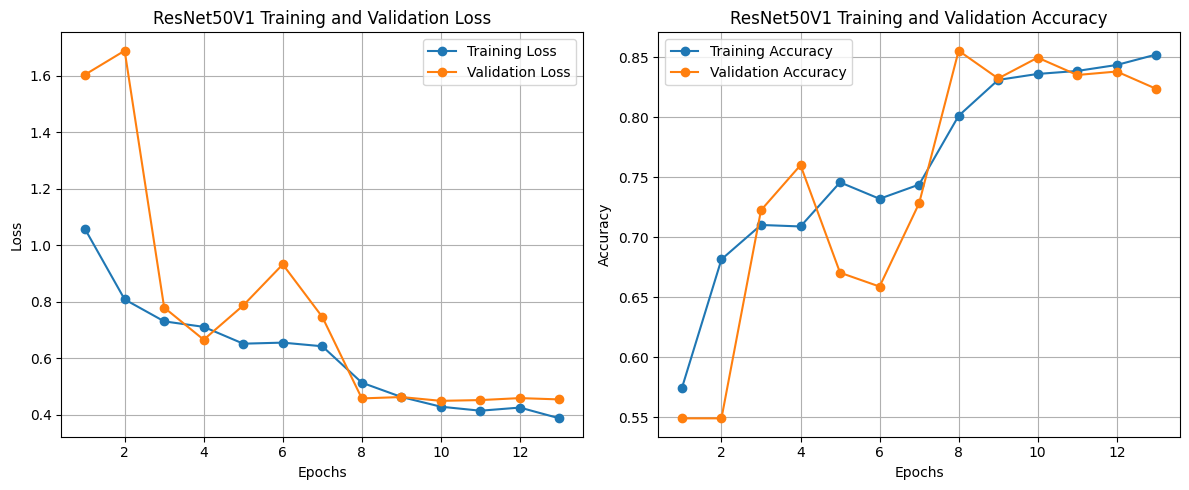


--- Evaluating ResNet50V1 on Test Set ---
Test Accuracy for ResNet50V1: 0.8426
Classification Report for ResNet50V1:
              precision    recall  f1-score   support

         abn       0.94      0.80      0.86       123
         bmt       0.66      0.66      0.66        29
        malg       0.62      0.85      0.72        40
         nml       0.90      0.94      0.92        65
         stn       0.89      0.90      0.89        86

    accuracy                           0.84       343
   macro avg       0.80      0.83      0.81       343
weighted avg       0.86      0.84      0.85       343



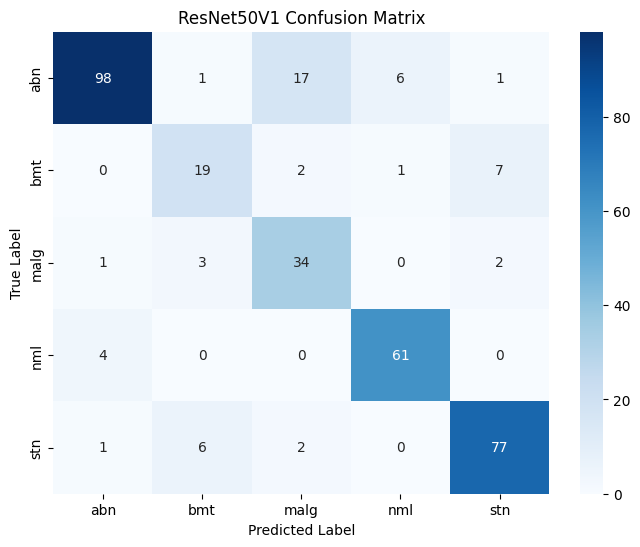

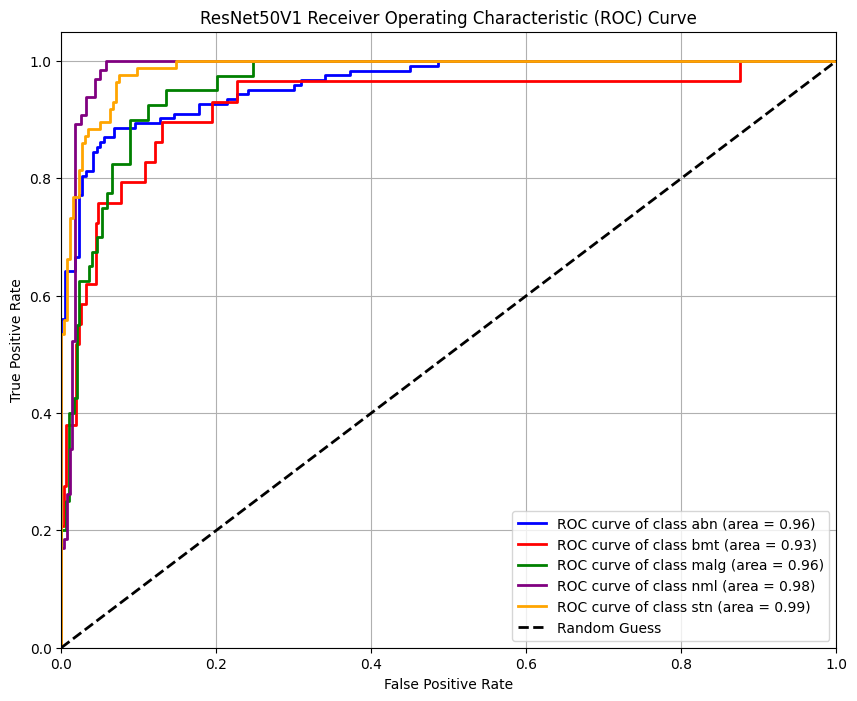

In [21]:
resnet50_v1_model = get_model("resnet50_v1", num_classes=len(class_names))
trained_resnet50_v1_model, train_loss_r50v1, val_loss_r50v1, train_acc_r50v1, val_acc_r50v1 = train_model(resnet50_v1_model, "ResNet50V1", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r50v1, val_loss_r50v1, train_acc_r50v1, val_acc_r50v1, "ResNet50V1")
y_true_r50v1, y_pred_classes_r50v1, y_pred_scores_r50v1 = evaluate_model_on_test(trained_resnet50_v1_model, "ResNet50V1")
plot_confusion_matrix(y_true_r50v1, y_pred_classes_r50v1, class_names, "ResNet50V1")
plot_roc_curve(label_binarize(y_true_r50v1, classes=list(range(NUM_CLASSES))), y_pred_scores_r50v1, NUM_CLASSES, class_names, "ResNet50V1")
all_trained_models.append(trained_resnet50_v1_model)

### ResNet-50 V2


--- Training ResNet50V2 ---
Epoch 0/29
----------
training Loss: 0.9283 Acc: 0.6355
validation Loss: 1.0838 Acc: 0.7052
Epoch 1/29
----------
training Loss: 0.7394 Acc: 0.7072
validation Loss: 0.7532 Acc: 0.7225
Epoch 2/29
----------
training Loss: 0.5639 Acc: 0.7975
validation Loss: 0.5995 Acc: 0.7803
Epoch 3/29
----------
training Loss: 0.5479 Acc: 0.7788
validation Loss: 0.7772 Acc: 0.7081
Epoch 4/29
----------
training Loss: 0.5183 Acc: 0.8006
validation Loss: 0.5962 Acc: 0.7717
Epoch 5/29
----------
training Loss: 0.4875 Acc: 0.8106
validation Loss: 0.6038 Acc: 0.7977
Epoch 6/29
----------
training Loss: 0.4266 Acc: 0.8361
validation Loss: 0.5976 Acc: 0.8006
Epoch 7/29
----------
training Loss: 0.3354 Acc: 0.8847
validation Loss: 0.3980 Acc: 0.8584
Epoch 8/29
----------
training Loss: 0.2831 Acc: 0.9003
validation Loss: 0.3915 Acc: 0.8613
Epoch 9/29
----------
training Loss: 0.2536 Acc: 0.9078
validation Loss: 0.3829 Acc: 0.8584
Epoch 10/29
----------
training Loss: 0.2278 Acc: 0

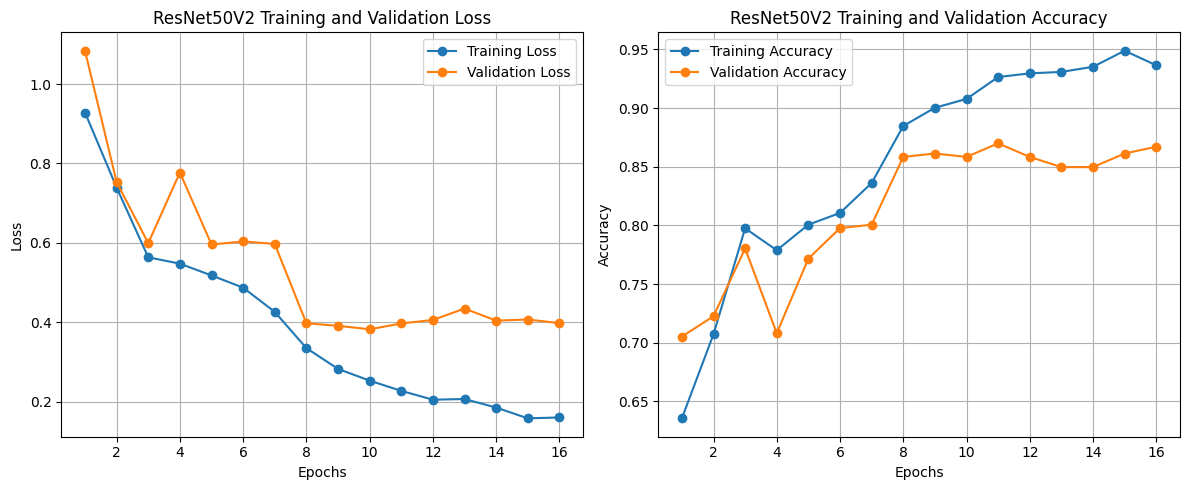


--- Evaluating ResNet50V2 on Test Set ---
Test Accuracy for ResNet50V2: 0.8484
Classification Report for ResNet50V2:
              precision    recall  f1-score   support

         abn       0.92      0.80      0.85       123
         bmt       0.72      0.79      0.75        29
        malg       0.59      0.80      0.68        40
         nml       0.91      0.92      0.92        65
         stn       0.93      0.91      0.92        86

    accuracy                           0.85       343
   macro avg       0.81      0.84      0.82       343
weighted avg       0.86      0.85      0.85       343



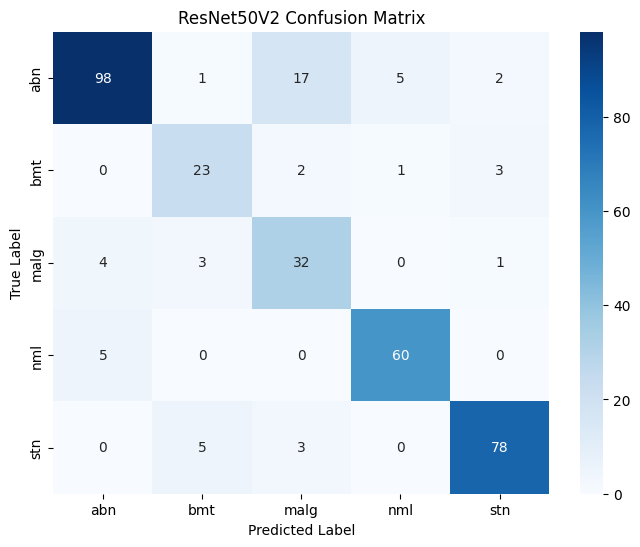

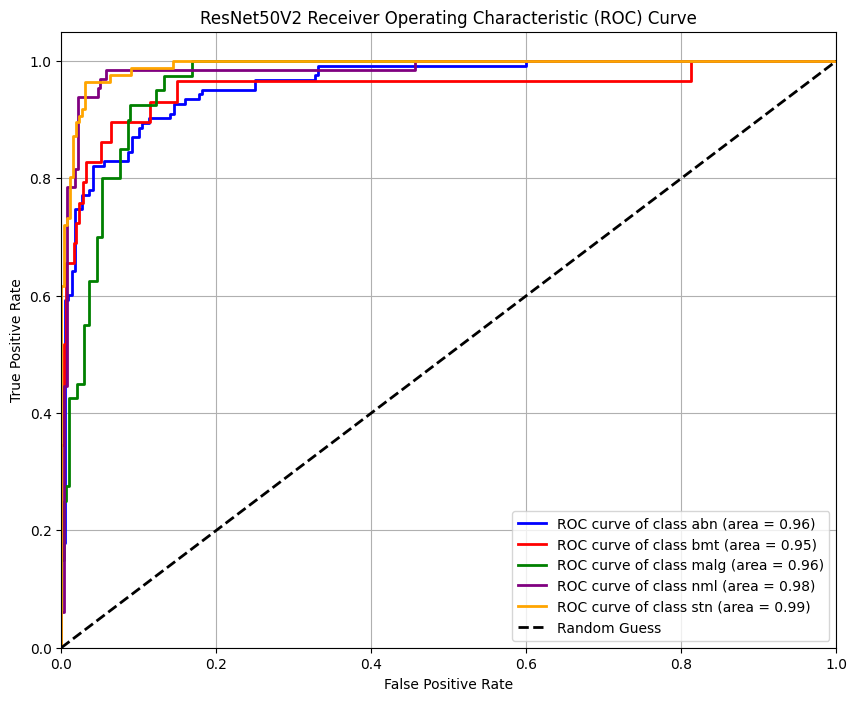

In [22]:
resnet50_v2_model = get_model("resnet50_v2", num_classes=len(class_names))
trained_resnet50_v2_model, train_loss_r50v2, val_loss_r50v2, train_acc_r50v2, val_acc_r50v2 = train_model(resnet50_v2_model, "ResNet50V2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r50v2, val_loss_r50v2, train_acc_r50v2, val_acc_r50v2, "ResNet50V2")
y_true_r50v2, y_pred_classes_r50v2, y_pred_scores_r50v2 = evaluate_model_on_test(trained_resnet50_v2_model, "ResNet50V2")
plot_confusion_matrix(y_true_r50v2, y_pred_classes_r50v2, class_names, "ResNet50V2")
plot_roc_curve(label_binarize(y_true_r50v2, classes=list(range(NUM_CLASSES))), y_pred_scores_r50v2, NUM_CLASSES, class_names, "ResNet50V2")
all_trained_models.append(trained_resnet50_v2_model)

### GBCNet


--- Training GBCNet ---
Epoch 0/29
----------
training Loss: 1.4872 Acc: 0.3570
validation Loss: 1.4027 Acc: 0.4249
Epoch 1/29
----------
training Loss: 1.3649 Acc: 0.4330
validation Loss: 1.2012 Acc: 0.5289
Epoch 2/29
----------
training Loss: 1.1844 Acc: 0.5296
validation Loss: 1.1604 Acc: 0.5520
Epoch 3/29
----------
training Loss: 1.0376 Acc: 0.5514
validation Loss: 0.9143 Acc: 0.6012
Epoch 4/29
----------
training Loss: 0.9796 Acc: 0.5850
validation Loss: 0.9333 Acc: 0.6012
Epoch 5/29
----------
training Loss: 0.8890 Acc: 0.6231
validation Loss: 0.8375 Acc: 0.6474
Epoch 6/29
----------
training Loss: 0.8359 Acc: 0.6417
validation Loss: 0.7694 Acc: 0.6879
Epoch 7/29
----------
training Loss: 0.7377 Acc: 0.6866
validation Loss: 0.7141 Acc: 0.7168
Epoch 8/29
----------
training Loss: 0.7204 Acc: 0.6928
validation Loss: 0.7007 Acc: 0.7139
Epoch 9/29
----------
training Loss: 0.7036 Acc: 0.7040
validation Loss: 0.6973 Acc: 0.7283
Epoch 10/29
----------
training Loss: 0.7122 Acc: 0.693

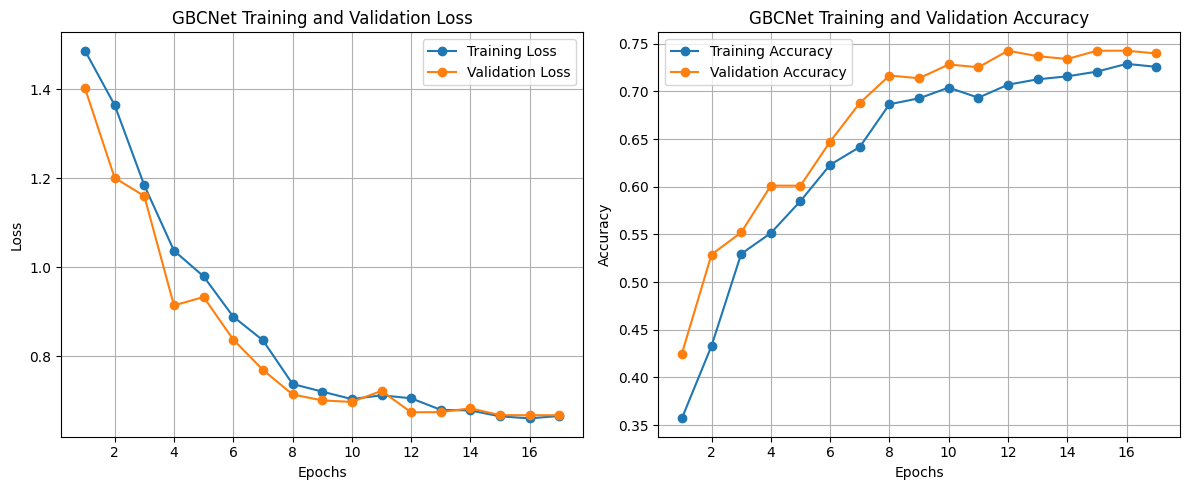


--- Evaluating GBCNet on Test Set ---
Test Accuracy for GBCNet: 0.7405
Classification Report for GBCNet:
              precision    recall  f1-score   support

         abn       0.74      0.80      0.77       123
         bmt       0.48      0.34      0.40        29
        malg       0.80      0.60      0.69        40
         nml       0.71      0.72      0.72        65
         stn       0.81      0.87      0.84        86

    accuracy                           0.74       343
   macro avg       0.71      0.67      0.68       343
weighted avg       0.73      0.74      0.73       343



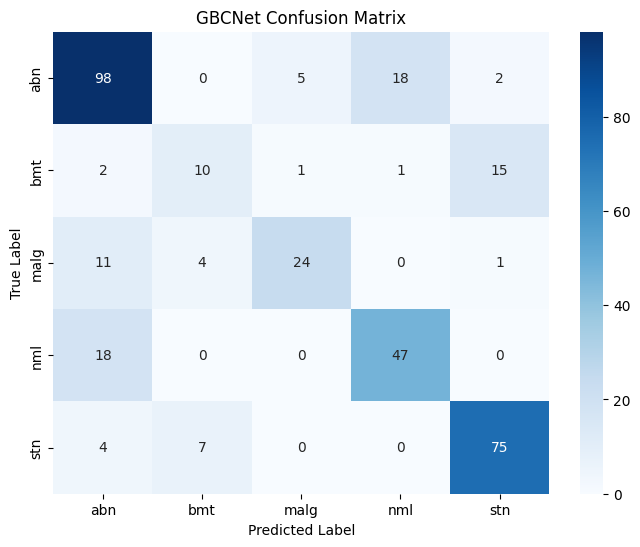

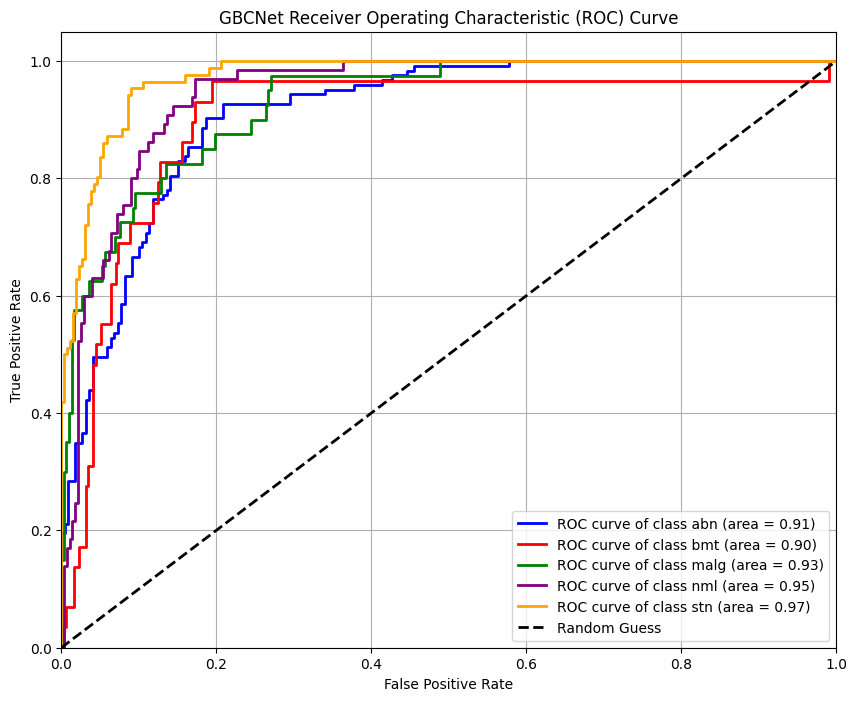

In [23]:
gbcnet_model = get_model("gbcnet", num_classes=len(class_names))
trained_gbcnet_model, train_loss_gbc, val_loss_gbc, train_acc_gbc, val_acc_gbc = train_model(gbcnet_model, "GBCNet", epochs=30, patience=5)
plot_accuracy_loss(train_loss_gbc, val_loss_gbc, train_acc_gbc, val_acc_gbc, "GBCNet")
y_true_gbc, y_pred_classes_gbc, y_pred_scores_gbc = evaluate_model_on_test(trained_gbcnet_model, "GBCNet")
plot_confusion_matrix(y_true_gbc, y_pred_classes_gbc, class_names, "GBCNet")
plot_roc_curve(label_binarize(y_true_gbc, classes=list(range(NUM_CLASSES))), y_pred_scores_gbc, NUM_CLASSES, class_names, "GBCNet")
all_trained_models.append(trained_gbcnet_model)

### RadFormer


--- Training RadFormer ---
Epoch 0/29
----------
training Loss: 2.6142 Acc: 0.2816
validation Loss: 1.5339 Acc: 0.3671
Epoch 1/29
----------
training Loss: 1.5190 Acc: 0.3445
validation Loss: 1.6003 Acc: 0.2514
Epoch 2/29
----------
training Loss: 1.5170 Acc: 0.3614
validation Loss: 1.4378 Acc: 0.3613
Epoch 3/29
----------
training Loss: 1.4713 Acc: 0.4044
validation Loss: 1.3389 Acc: 0.4306
Epoch 4/29
----------
training Loss: 1.3240 Acc: 0.4480
validation Loss: 1.4909 Acc: 0.3960
Epoch 5/29
----------
training Loss: 1.2882 Acc: 0.4735
validation Loss: 1.3802 Acc: 0.4595
Epoch 6/29
----------
training Loss: 1.1904 Acc: 0.5121
validation Loss: 1.6231 Acc: 0.4075
Epoch 7/29
----------
training Loss: 1.0464 Acc: 0.5607
validation Loss: 1.2460 Acc: 0.4971
Epoch 8/29
----------
training Loss: 0.9882 Acc: 0.5813
validation Loss: 1.2368 Acc: 0.4855
Epoch 9/29
----------
training Loss: 0.9466 Acc: 0.6100
validation Loss: 1.2825 Acc: 0.4798
Epoch 10/29
----------
training Loss: 0.9423 Acc: 0.

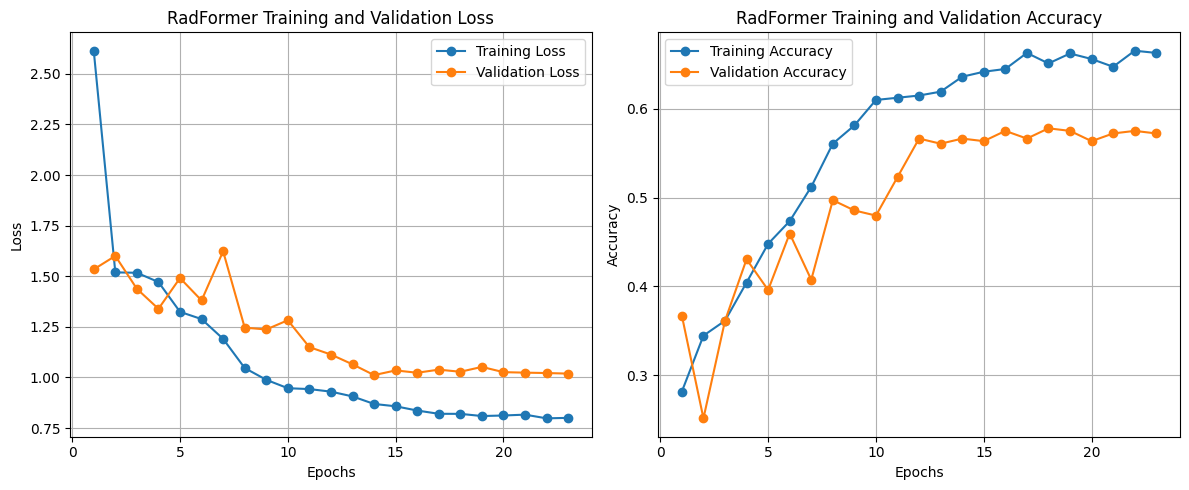


--- Evaluating RadFormer on Test Set ---
Test Accuracy for RadFormer: 0.6064
Classification Report for RadFormer:
              precision    recall  f1-score   support

         abn       0.57      0.74      0.64       123
         bmt       0.54      0.24      0.33        29
        malg       0.52      0.62      0.57        40
         nml       0.68      0.20      0.31        65
         stn       0.70      0.84      0.76        86

    accuracy                           0.61       343
   macro avg       0.60      0.53      0.52       343
weighted avg       0.62      0.61      0.57       343



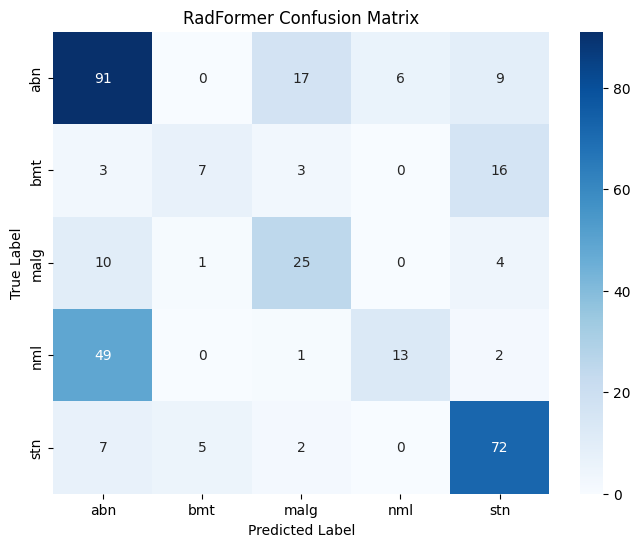

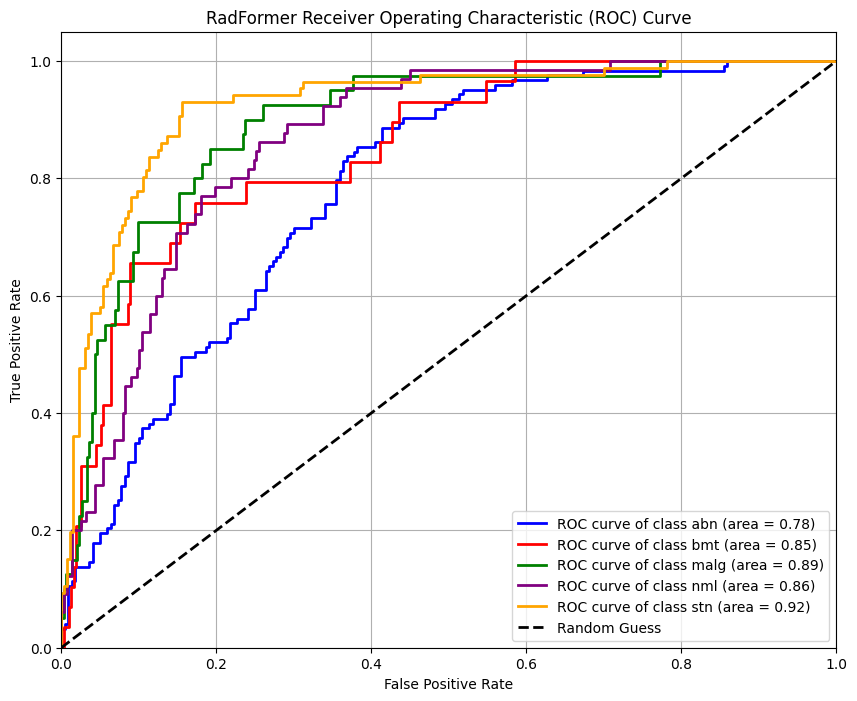

In [24]:
radformer_model = get_model("radformer", num_classes=len(class_names))
trained_radformer_model, train_loss_rad, val_loss_rad, train_acc_rad, val_acc_rad = train_model(radformer_model, "RadFormer", epochs=30, patience=5)
plot_accuracy_loss(train_loss_rad, val_loss_rad, train_acc_rad, val_acc_rad, "RadFormer")
y_true_rad, y_pred_classes_rad, y_pred_scores_rad = evaluate_model_on_test(trained_radformer_model, "RadFormer")
plot_confusion_matrix(y_true_rad, y_pred_classes_rad, class_names, "RadFormer")
plot_roc_curve(label_binarize(y_true_rad, classes=list(range(NUM_CLASSES))), y_pred_scores_rad, NUM_CLASSES, class_names, "RadFormer")
all_trained_models.append(trained_radformer_model)

### Ensemble Evaluation


--- Performing Ensemble Evaluation ---
Ensemble Test Accuracy: 0.8717
Ensemble Classification Report:
              precision    recall  f1-score   support

         abn       0.92      0.84      0.88       123
         bmt       0.81      0.72      0.76        29
        malg       0.65      0.85      0.74        40
         nml       0.91      0.94      0.92        65
         stn       0.93      0.93      0.93        86

    accuracy                           0.87       343
   macro avg       0.84      0.86      0.85       343
weighted avg       0.88      0.87      0.87       343



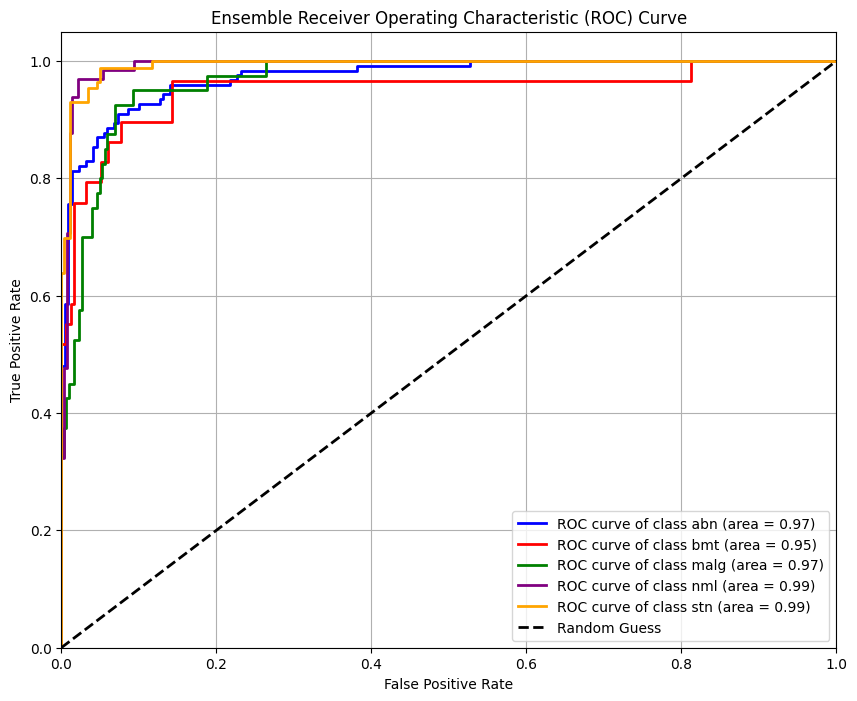

In [25]:
ensemble_accuracy, ensemble_probs, y_true_ensemble = ensemble_evaluate(all_trained_models, test_loader, class_names, device)
model_results["Ensemble"] = ensemble_accuracy
plot_roc_curve(label_binarize(y_true_ensemble, classes=list(range(NUM_CLASSES))), ensemble_probs, NUM_CLASSES, class_names, "Ensemble")

### Table

In [26]:
print("\nModel Performance Summary (Including Ensemble - All Test Accuracies):\\n")
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Test Accuracy"])
results_df["Test Accuracy"] = results_df["Test Accuracy"].apply(lambda x: f"{x*100:.2f}%")
results_df = results_df.sort_values(by="Test Accuracy", ascending=False) # Sort by accuracy

print(results_df.to_string(index=False))


Model Performance Summary (Including Ensemble - All Test Accuracies):\n
         Model Test Accuracy
      Ensemble        87.17%
EfficientNetB0        86.30%
   MobileNetV2        86.01%
   DenseNet201        85.71%
EfficientNetB1        85.42%
      ResNet18        85.13%
   DenseNet121        85.13%
EfficientNetB4        84.84%
    ResNet50V2        84.84%
    ResNet50V1        84.26%
  ShuffleNetV2        83.67%
EfficientNetB2        83.38%
EfficientNetB3        83.38%
        GBCNet        74.05%
    SqueezeNet        67.35%
     RadFormer        60.64%
